# Hradness properties of a polycrystal
This notebook and the accompanying code demonstrates how to use the Graph Nets library to learn to predict the hardness map of a polycrystal.

The network is trained to predict the load-depth curves of nanoindented grains in steel. 

After training, the network's prediction ability is illustrated by comparing its output to the true hardness of the material.

# Install dependencies locally

If you are running this notebook locally (i.e., not through Colaboratory), you will also need to install a few more dependencies. Run the following on the command line to install the graph networks library, as well as a few other dependencies:

```
pip install graph_nets matplotlib scipy "tensorflow>=1.15,<2" "dm-sonnet<2" "tensorflow_probability<0.9"

In [1]:
install_graph_nets_library = "No"  #param ["Yes", "No"]

if install_graph_nets_library.lower() == "yes":
  print("Installing Graph Nets library and dependencies:")
  print("Output message from command:\n")
  !pip install graph_nets "dm-sonnet<2" "tensorflow_probability<0.9"
else:
  print("Skipping installation of Graph Nets library")

Skipping installation of Graph Nets library


# load libraries

In [160]:
import configparser
confParser = configparser.ConfigParser()
confParser.read('config.ini')
confParser.sections()


['Parameters',
 'flags',
 'gnn library path',
 'python libarary path',
 'test data files']

In [198]:
import sys
sys.path.append(confParser['gnn library path']['gnnLibDir'])
sys.path.append(confParser['python libarary path']['pyLibDir'])
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import pdb
import utility as utl
import warnings
warnings.filterwarnings('ignore')
import matplotlib
matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
import os
import traceback
import imp
imp.reload(utl)
from scipy.spatial import KDTree
from scipy.interpolate import Rbf
import time

import functools
from typing import Any, Dict, Text,Tuple,Optional


import enum
import pickle
#from absl import logging
import numpy as np


import tensorflow.compat.v1 as tf
import tensorflow_probability as tfp

import sonnet as snt

from graph_nets import graphs
from graph_nets import modules as gn_modules
from graph_nets import utils_tf
from gnn_graphnet_model import *
from graph_nets import utils_np

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from scipy import stats

SEED =4441666
np.random.seed(SEED)
tf.set_random_seed(SEED)

# utility funcs

In [4]:
class AddMissing:
    '''
    interpolate using k-nearest neighbors
    '''
    def __init__(self,cords,val,query_index):

        self.query_index = query_index.flatten()
        self.points    = cords
        self.val = val.copy()

    def kdTree(self,k):
        tree = KDTree( self.points )
        dd, ii = tree.query([self.points], k=k)
        self.neigh_mat= ii[0] #--- nearest neighbor matrix
        
    def interpolate(self):
        #--- nearest neighbor values
        h_mat = np.c_[list(map(lambda x:self.val[x].flatten(),self.neigh_mat))]
        assert np.all(list(map(lambda x:np.any(x>0.0),h_mat))), 'increase k!'
        #--- filter query points
        h_list = list(map(lambda x:x[x>0.0],h_mat[self.query_index]))
        assert len(h_list) == h_mat[self.query_index].shape[0]
        
        #--- average
        h_mean = list(map(lambda x: x.mean(), h_list))
        query_rows = np.arange(self.query_index.shape[0])[self.query_index]
        self.val[query_rows] = np.c_[h_mean]

        
        
def load_test_data(test_data_file_path,test_data_file_path2nd):
    # read the csv file and return the text line list.
    test_data_row_list = pd.read_csv(test_data_file_path,sep=',')
    test_data_row_list2nd = pd.read_csv(test_data_file_path2nd,sep=',')
    print('open and load data from test_data.csv complete.')
    return test_data_row_list, test_data_row_list2nd



    
def base_graph( 
               test_data_file_path, 
               test_data_file_path2nd,
               predictors,
                forces,
                train_mask,
                test_mask,
                attributes,
               logtrans=False
              ):
    """
    This here loads the data and forms a graph structure. This should be implemented as it is dataset-dependent.
    Output should be:
        a dict with  globals (dummy), nodes (nodal data in numpy), edges (edge data), receivers (indices of receiving node in int), senders (int)
        train_mask   array of size (n_nodes) with bool or 0/1 indicating training nodes
        val_mask     same for validation nodes 
        test_mask    same for testing nodes
        target 	     here the array containing the nodal target data
        weight	     if needed, a weight parameter given for the (training) nodes
    """
    
    test_data, test_data2nd = load_test_data(test_data_file_path, 
                                             test_data_file_path2nd
                                            )
    #--- do interpolation for missing attributes
#     interp = AddMissing(np.c_[test_data[['x','y']]],
#                          np.c_[test_data['h(Gpa)']],
#                          np.c_[test_data['h(Gpa)']==0.0],
#                                )

#     interp.kdTree(64) #--- nearest neighbors
#     interp.interpolate()

#     #--- update data frame
#     cols = list(test_data.keys())
#     cols.remove('h(Gpa)')
#     test_data = pd.DataFrame(np.c_[test_data[cols],interp.val.flatten()],columns=cols+['h(Gpa)'])

    
    #--- assignment
    positions = np.c_[test_data[attributes],forces].tolist()
#    pdb.set_trace()
    edges = list(map(lambda x:[x],np.array(test_data2nd['misOrientationAngle(deg)'])))
    receivers = list(test_data2nd['grain_j_index'].astype(int))
    senders = list(test_data2nd['grain_i_index'].astype(int)) 
    
    #--- target vector
#     xp=np.arange(0,1,0.01)
#     y=test_data['boundarySize'].apply(lambda x:x*xp**2+np.random.normal(size=len(xp)))
#     y = np.c_[y.to_list()]

#     predictors = np.c_[test_data['x']+np.random.random(size=test_data.shape[0])] ###### comment
#    print(predictors.shape)
    target = list(map(lambda x:list(x),predictors))
    #list(map(lambda x:[x],np.array(test_data['h(Gpa)']))) #list(map(lambda x:list(x),y)) #
#    target =  list(map(lambda x:[x],np.array(test_data['h(Gpa)'])))
    
#    train_mask = np.all(~np.isnan(predictors),axis=1)
    #train_test_split(test_data['x'],test_data['y']) #--- change!!!!
    
    val_mask = test_mask # = ~train_mask
    weight = list(np.ones(test_data.shape[0]))

    return {"globals": [0.0],  "nodes": positions, "edges": edges,  
            "receivers": receivers, "senders": senders  },\
            train_mask, val_mask, test_mask, target, weight 

#    return {"globals": [0.0],  "nodes": nodes_data[:,1:], "edges": edges_data[:,2:],  
#            "receivers": edges_data[:,1].astype(int), "senders": edges_data[:,0].astype(int)  }, 
#            train_mask, val_mask, test_mask, target, weight 



def create_loss_ops(target_op, output_op, mask, weight=None):
    """Create supervised loss operations from targets and outputs.

    Args:
      target_op: The target tf.Tensor.
      output_ops: The output graph from the model.

    Returns:
      loss values (tf.Tensor)
    """
    if weight is None:
#         pdb.set_trace()
        loss_op = tf.reduce_mean(  (  tf.boolean_mask(output_op.nodes, mask) - tf.boolean_mask(target_op, mask))**2)
    else:
        loss_op = tf.reduce_mean( tf.boolean_mask(weight, mask)* (  tf.boolean_mask(output_op.nodes, mask) - tf.boolean_mask(target_op, mask))**2)

    return loss_op


def create_corr_ops(target_op, output_op, mask):
    corr_op = tfp.stats.correlation(tf.boolean_mask(target_op, mask), tf.boolean_mask(output_op.nodes, mask))
    return corr_op




# Creating graphs

## target data

In [5]:
class Finder():
    '''
    return a list of files in a directory
    '''
    def __init__(self,path_ld):
        self.files = os.listdir(path_ld)

    def Get(self,file_index):
        return self.files[file_index]
    
class TestData:
    '''
    return the feature matrix
    '''
    ld_curve = {}
    load = {}
    
    def __init__(self,path_ld,path_gb,verbose=False):
        self.path_ld = path_ld #--- ld data
        self.path_gb = path_gb #--- grain properties
        self.verbose = verbose

    def is_included(self,xlo,xhi):
        '''
        return bool: timeseries includes the range (xlo,xhi) 
        '''
        return self.data[:,0].min() <= xlo and self.data[:,0].max() >=  xhi   
            
    def Parse(self):
        if self.verbose:
            print('parsing %s'%(self.path_ld))
        self.data    = np.loadtxt( self.path_ld ) #--- load curve
        self.grains  = pd.read_csv(self.path_gb ,sep=',')
        
    def Interp(self,bins):
        '''
        interpolate on the structured grid bins
        '''
#        self.xsum = np.interp(bins, self.data[:,0], self.data[:,1], left=None, right=None, period=None)
#        self.edges = bins
        
        self.xsum = self.Rbf(self.data[:,1],len(bins))
        self.edges = self.Rbf(self.data[:,0],len(bins))
        
    def Rbf(self,data,nbins):
        x = np.linspace(0, 1, data.shape[0])
        d = data 
        rbfi = Rbf(x, d)
        xi = np.linspace(0, 1, nbins)
        return rbfi(xi)
            
    def GetGrainIndex(self):
        '''
        return grain index and id 
        '''
        GetGrainID = lambda x:x[x.find('ID_')+3:x.find('_LoadID')]
        GrainID = GetGrainID(self.path_ld)
        filtr = self.grains['#grainID']==float(GrainID)
        assert np.any(filtr), 'grainID %s not exist!'%GrainID
        return self.grains[filtr].index[0]

    def Scale(self):
        '''
        return scaled data 
        '''
        self.data[:,0] /= np.max(self.data[:,1]) #--- scale by fmax
        self.data[:,1] /= np.max(self.data[:,1])
        
    @staticmethod
    def ReplaceNanByMean(forces):
        mean_force_array = np.mean(forces[~np.any(np.isnan(forces),axis=1)],axis=0) #--- replace missing data by the average
        isnan = np.any(np.isnan(forces),axis=1)
        
        for grain_indx in range(len(forces)):
            if isnan[grain_indx]:
                forces[grain_indx] = np.copy(mean_force_array)


    @staticmethod
    def Append(GrainIndex,disp,load):
        '''
        append stress timeseries
        '''
        TestData.ld_curve.setdefault(GrainIndex,[]).append(disp.copy()) #--- repetative
        TestData.load.setdefault(GrainIndex,[]).append(load.copy()) #--- repetative
        
    
    @staticmethod
    def BuildFeature(sdict,ngrains_total,n_ld):
    #--- build feature matrix
        keys=list(sdict.keys()) #--- indented grains
        mat = np.c_[list(map(lambda x:np.mean(np.c_[sdict[x]],axis=0),keys))] #--- matrix
#         print(mat.shape)
        df = pd.DataFrame(np.c_[keys,mat]) #--- data frame
        df.sort_values(0,inplace=True)

        #--- non-indented grains
    #    =
        ngrains_indented = df.shape[0]
    #    n_ld = np.arange(xlo,xhi,dx).shape[0]
        ngrains = ngrains_total - ngrains_indented
        mat_nan = np.ones(ngrains*n_ld).reshape((ngrains,n_ld))*np.nan

        #--- combine
        mat_new = np.concatenate([df.drop(columns=[0]),mat_nan],axis=0)

    #--- row number
        ids=list(range(ngrains_total))
        list(map(lambda x:ids.remove(x),keys))
        keys = keys + ids

        df = pd.DataFrame(np.c_[keys,mat_new])
        return np.c_[df.drop(columns=[0])]

mkdir: cannot create directory ‘png’: File exists


'loadDepth_GrainID_704_LoadID0_IndentLabel_10.txt'

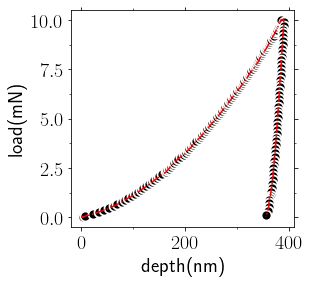

<AxesSubplot:xlabel='depth(nm)', ylabel='load(mN)'>

In [6]:
!mkdir png
symbols=utl.Symbols()

finder=Finder(confParser['test data files']['load_depth_path'])
display(finder.Get(1))

#--- parse load curve
test_data = TestData(path_ld='%s/%s'%(confParser['test data files']['load_depth_path'],finder.Get(1)),
                     path_gb=confParser['test data files']['test_data_file_path'],
                    )

test_data.Parse()
#test_data.Scale()
ax=utl.PltErr(test_data.data[:,0],test_data.data[:,1],
#                xlim=(0,20),ylim=(0,0.2),
               attrs=symbols.GetAttrs(count=0,fmt='.',nevery=2),
              Plot=False,
               )
test_data.Interp(bins=np.arange(test_data.data[:,0].min(),test_data.data.max(),0.1))
utl.PltErr(test_data.edges,test_data.xsum,
#                xlim=(0,20),ylim=(0,0.2),
               attrs={'fmt':'-.r'},
                ax=ax,
               xstr='depth(nm)',
               ystr='load(mN)',
#               attrs=symbols.GetAttrs(fmt='-.r'),
               title='png/loadDepth.png'
            
                )

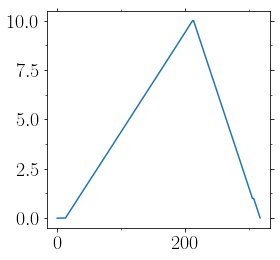

In [7]:
# ax=utl.PltErr(range(test_data.data[:,1].shape[0]),test_data.data[:,1],
# #                xlim=(0,20),ylim=(0,0.2),
#                attrs={'fmt':'-'},
# #              Plot=False,
#                )


### multiple grains

open and load data from test_data.csv complete.
no GrainIndex for  loadDepth_GrainID_nan_LoadID11_IndentLabel_2.txt
no GrainIndex for  loadDepth_GrainID_nan_LoadID11_IndentLabel_4.txt
no GrainIndex for  loadDepth_GrainID_nan_LoadID11_IndentLabel_1.txt
no GrainIndex for  loadDepth_GrainID_nan_LoadID11_IndentLabel_3.txt
# of indentation exp. is  176
grains with more than one indentation data:  (31,)
# of indented grains:  131


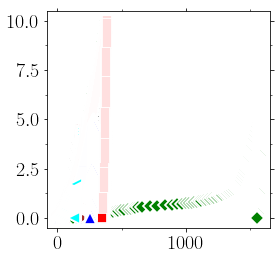

In [8]:
def GetDuplicateGrains():
    s=np.array(list(map(lambda x:len(TestData.ld_curve[x]),TestData.ld_curve.keys())))
    mask = s>1
    print('grains with more than one indentation data: ',np.array(list(TestData.ld_curve.keys()))[mask].shape)

    
test_data_file_path = confParser['test data files']['test_data_file_path']
test_data_file_path2nd = confParser['test data files']['test_data_file_path2nd']
test_data_grains, test_data_grains2nd = load_test_data(test_data_file_path, 
                                         test_data_file_path2nd
                                        )
ngrains = test_data_grains.shape[0]

ax  = utl.PltErr(None,None,Plot=False)

#--- prescribed range for displacements 
(xlo,xhi,dx)=(0.0,1.0,0.01)

#--- loop over indented grains
TestData.ld_curve = {}
TestData.load = {}
count_indented = 0
for fp,count in zip(finder.files,range(len(finder.files))):
    test_data = TestData(path_ld='%s/%s'%(confParser['test data files']['load_depth_path'],fp),
                     path_gb=confParser['test data files']['test_data_file_path'],
                     verbose=False,
                    )
    test_data.Parse()
#    test_data.Scale() #--- scale features
#    if not test_data.is_included(xlo,xhi): #--- ld curve includes this range
#        continue
    test_data.Interp(bins=np.arange(xlo,xhi,dx)) #--- interpolate
    try:
        GrainIndex = test_data.GetGrainIndex() #--- could be a nan!
    except:
        print('no GrainIndex for ',fp)
        continue
        
    if np.any(np.isnan(test_data.data[:,1])):
            print('nan in displacements: ',fp)

    #--- plot
    utl.PltErr(test_data.data[:,0],test_data.data[:,1],
                attrs=symbols.GetAttrs(count=count%7),
               ax=ax,Plot=False,
#               xlim=(0,100),#xhi),# ylim=(0,6),
              )
    TestData.Append(GrainIndex,test_data.edges,test_data.xsum) #--- assemble feature matrix: append displacements
    
    count_indented += 1
print('# of indentation exp. is ',count_indented)

GetDuplicateGrains()
#--- predictors are the displacements
predictors = TestData.BuildFeature(TestData.ld_curve, 
                                   ngrains,
                                   np.arange(xlo,xhi,dx).shape[0]
                                  )

#---- forces
forces = TestData.BuildFeature(TestData.load, 
                                   ngrains,
                                   np.arange(xlo,xhi,dx).shape[0]
                                  )
TestData.ReplaceNanByMean(forces)

print('# of indented grains: ',(~np.any(np.isnan(predictors),axis=1)).sum())

In [164]:
test_data_grains

,Unnamed: 0,#grainID,x,y,grainSize,perimeter,boundarySize,numNeighbors,h(Gpa)
0,0,84.0,-39.29250,-11.737050,140.0,45.26390,98.0,9.0,1.450
1,1,85.0,-55.00100,-9.001784,305.0,74.94776,159.0,6.0,3.619
2,2,122.0,-89.87787,-17.845570,70.0,52.65392,114.0,9.0,4.334
3,3,133.0,-224.73250,-22.966570,367.0,102.53660,222.0,12.0,3.733
4,4,142.0,-105.03070,-20.043080,185.0,60.96770,132.0,4.0,6.050
...,...,...,...,...,...,...,...,...,...
1077,1077,1077.0,-213.29750,-321.192600,14.0,14.90381,28.0,4.0,0.000
1078,1078,1078.0,-222.83610,-320.931200,108.0,47.23516,78.0,4.0,0.000
1079,1079,1079.0,-234.40920,-319.875300,29.0,24.14134,48.0,5.0,0.000
1080,1080,1080.0,-239.53090,-320.622300,70.0,35.22637,58.0,3.0,0.000


In [39]:
#plt.plot(test_data_grains['perimeter'],test_data_grains['boundarySize'])

### missing data

In [9]:
class AddMissing:
    '''
    interpolate using k-nearest neighbors
    '''
    def __init__(self,cords,val,query_index,verbose=False):

        self.query_index = query_index.flatten()
        self.points    = cords
        self.val = val.copy()
        self.verbose = verbose

    def kdTree(self,k):
        tree = KDTree( self.points )
        dd, ii = tree.query([self.points], k=k)
        self.neigh_mat= ii[0] #--- nearest neighbor matrix
        if self.verbose:
            print('neigh_mat.shape:',self.neigh_mat.shape)
        
    def interpolate(self):
        #--- nearest neighbor values
        h_mat = np.c_[list(map(lambda x:self.val[x],self.neigh_mat))]
        if self.verbose:
            print('h_mat.shape:',h_mat.shape)
        assert np.all(list(map(lambda x:np.any(~np.isnan(x)),h_mat))), 'increase k!'
        #--- filter query points
        h_list = list(map(lambda x:x[np.all(~np.isnan(x),axis=1)],h_mat[self.query_index]))
        assert len(h_list) == h_mat[self.query_index].shape[0]
        
        #--- average
        h_mean = list(map(lambda x: np.mean(x,axis=0), h_list))
        if self.verbose:
            print('h_mean.shape:',h_mean[0].shape)
        query_rows = np.arange(self.query_index.shape[0])[self.query_index]
        self.val[query_rows] = np.c_[h_mean]

        

# interp0 = AddMissing(np.c_[test_data_grains[['x','y']]],
#                      predictors,#np.c_[df.drop(columns=[0])],
#                      np.all(np.isnan(predictors),axis=1),
#                      verbose=True,
#                            )

# interp0.kdTree(64) #--- nearest neighbors
# interp0.interpolate()
# predictors = interp0.val.shape

## build graph

### train-test split

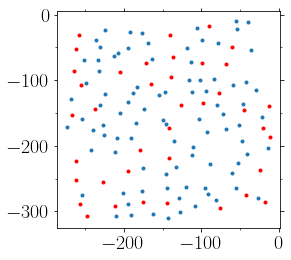

<AxesSubplot:>

In [10]:
def train_test_split(mask,test_size=.3, train_size=.7, random_state=128): #x,y):
    '''
    Split arrays or matrices into random train and test subsets.
    '''
    n=mask.shape[0]
    indented_indices = np.arange(n)[mask]
    n_indented = indented_indices.shape[0]
    np.random.seed(random_state)
    np.random.shuffle(indented_indices)
    #
    m=int(test_size*n_indented)
    test_set_indices = indented_indices[:m] #--- test set indices
    test_set=np.zeros(n,dtype=bool)
    test_set[test_set_indices]=True #--- assign True to test set oindices

    #
    m=int(train_size*n_indented)
    train_set_indices=indented_indices[n_indented-m:n_indented]
    train_set=np.zeros(n,dtype=bool)
    train_set[train_set_indices]=True #--- assign True to test set oindices
    
    return train_set, test_set
    

        #     xlo, xhi = x.min(), x.max()
#     ylo, yhi = y.min(), y.max()
#     x_copy = np.array(x.copy() - xlo)
#     y_copy = np.array(y.copy() - ylo)
    
#     return x_copy < 0.7 * (xhi-xlo)

mask = np.all(~np.isnan(predictors),axis=1) #--- indented grains

#--- train-test split
train_mask, test_mask =  train_test_split(mask)

#--- plot
ax=utl.PltErr(test_data_grains[train_mask]['x'],test_data_grains[train_mask]['y'],
              attrs={'fmt':'.'},
             Plot=False
             )

utl.PltErr(test_data_grains[test_mask]['x'],test_data_grains[test_mask]['y'],
              attrs={'fmt':'.','color':'red'},
           ax=ax
             )

In [11]:
def train_test_split(mask,cv=3):
    '''
    Split arrays or matrices into random train and test subsets for cross validation.
    '''
    assert cv > 1, '# of partitions must be greater than 2'
    n=mask.shape[0]
    indented_indices = np.arange(n)[mask]
    n_indented = indented_indices.shape[0]
    np.random.seed(128)
    np.random.shuffle(indented_indices)
    m=int(n_indented/cv)
    test_set = {}
    for i in range(cv-1):
        test_set[i] = indented_indices[i*m:(i+1)*m] #--- test set indices
    test_set[i+1] = indented_indices[(i+1)*m:n_indented]
    assert n_indented == np.sum(list(map(lambda x:test_set[x].shape[0],test_set.keys())))
    #
    mask_dic = {}
    for i in range(cv):
        tmp_test=np.zeros(n,dtype=bool)
        tmp_test[test_set[i]]=True #--- assign True to test set oindices
        tmp_train = np.all([mask,~tmp_test],axis=0)
        assert not np.any(np.all([tmp_train,tmp_test],axis=0))
        mask_dic[i]={}
        mask_dic[i]['test'] = np.copy(tmp_test)
        mask_dic[i]['train'] = np.copy(tmp_train)
        
    return mask_dic

# mask = np.all(~np.isnan(predictors),axis=1) #--- indented grains
# train_test_split(mask,cv=3)

# #--- plot
# for i in range(3):
#     train_mask=train_test_split(mask,cv=3)[i]['train']
#     ax=utl.PltErr(test_data_grains[train_mask]['x'],test_data_grains[train_mask]['y'],
#                   attrs={'fmt':'.'},
#                  Plot=False
#                  )

#     test_mask=train_test_split(mask,cv=3)[i]['test']
#     utl.PltErr(test_data_grains[test_mask]['x'],test_data_grains[test_mask]['y'],
#                   attrs={'fmt':'.','color':'red'},
#                ax=ax
#                  )

In [12]:
def GetSubset(mask,fraction):
    n=mask.shape[0]
    indented_indices = np.arange(n)[mask]
    n_indented = indented_indices.shape[0]
    np.random.seed(128)
    np.random.shuffle(indented_indices)
    m=int(fraction*n_indented)
    test_set = indented_indices[:m] #--- test set indices
    #
    tmp_test=np.zeros(n,dtype=bool)
    tmp_test[test_set]=True #--- assign True to test set oindices
    return tmp_test



In [13]:
def BadGrains(mask,slist):
    for i in slist:
        mask[i]=False
#BadGrains(train_mask,[0,21,43,50,83,86,100,109,112])
#BadGrains(test_mask, [0,21,43,50,83,86,100,109,112])

### input graph

In [14]:
#tf.set_random_seed(1234)
#tf.get_default_graph().finalize() # something everybody tends to forget


pure_lab='' 
data_split = None
data_split_lab=''
#


#--- path for csv data files
# test_data_file_path=confParser['test data files']['test_data_file_path']
# test_data_file_path2nd=confParser['test data files']['test_data_file_path2nd']


#--- graph structure  
static_graph_tr, train_mask_np, val_mask_np, test_mask_np,\
target_nodes_np, weight_np = base_graph(test_data_file_path, 
                                        test_data_file_path2nd,
                                        predictors,
                                        forces,
                                        train_mask,
                                        test_mask,
                                        confParser['Parameters']['attributes'].split(), #--- attributes
                                        logtrans=data_split)
print(static_graph_tr.keys())
for k in static_graph_tr.keys():
    try:
        print(k, static_graph_tr[k].shape)
    except AttributeError:
        print(k)

input_graph = utils_tf.data_dicts_to_graphs_tuple([static_graph_tr])
graphs_tuple = utils_np.data_dicts_to_graphs_tuple([static_graph_tr])
#print(input_graph)
print('nodes matrix shape:',np.array(static_graph_tr['nodes']).shape)


open and load data from test_data.csv complete.
dict_keys(['globals', 'nodes', 'edges', 'receivers', 'senders'])
globals
nodes
edges
receivers
senders
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
nodes matrix shape: (1082, 106)


In [47]:
# import json
# with open('graph.json','w') as fp:
#     json.dump(static_graph_tr,fp)

In [48]:
#json.load(open('graph.json')).keys()

## Visualize 
### euclidean space

### plot h map

In [16]:
class interpolate:
    '''
    interpolate using k-nearest neighbors
    '''
    def __init__(self,cords,val,query_points):

        self.points    = cords
        self.query_points = query_points
        self.val = val.copy()

    def kdTree(self):
        tree = KDTree( self.points )
        dd, ii = tree.query([self.query_points], k=1)
        self.neigh_mat= ii[0] #--- nearest neighbor matrix
        
        
    def interpolate(self):        
        return self.val[self.neigh_mat.flatten()]

    #--- do interpolation for missing attributes
# interp = AddMissing(np.c_[test_data_grains[['x','y']]],
#                      np.c_[test_data_grains['h(Gpa)']],
#                      np.c_[test_data_grains['h(Gpa)']==0.0],
#                            )

# interp.kdTree(64) #--- nearest neighbors
# interp.interpolate()

# #--- update data frame
# cols = list(test_data_grains.keys())
# cols.remove('h(Gpa)')
# test_data = pd.DataFrame(np.c_[test_data_grains[cols],interp.val.flatten()],columns=cols+['h(Gpa)'])


# #--- discrete set of points 
# points=np.c_[test_data[['x','y']]]# #[static_graph_tr['nodes']][:,0:2]
    
# #--- plot hardness map
# [xlo,xhi]=[points[:,0].min(),points[:,0].max()]
# [ylo,yhi]=[points[:,1].min(),points[:,1].max()]
# dx=dy=0.5
# xlin = np.arange(xlo,xhi,dx)
# ylin = np.arange(ylo,yhi,dy)
# xv,yv=np.meshgrid(xlin,ylin)
# query_points = list(zip(xv.flatten(),yv.flatten()))

# #--- interpolate
# interp = interpolate(points,
#                      np.c_[test_data['h(Gpa)']],#' np.array(target_nodes_np),
#                      np.c_[query_points],
#                            )
# interp.kdTree()
# vi = interp.interpolate()
# vi = vi.reshape((xv.shape))

# #--- imshow
# n=vi.T.shape[1]
# val=np.array([vi.T[:,(n-1)-j] for j in range(n)])
# val.shape
# utl.PltBitmap( val.T,
#                xlabel = '$y$', ylabel = '$x$',
#                xlim = (yhi,ylo), ylim = (xlo,xhi),
#                frac = 1.0, #--- plot a patch
#                zscore = False,
#                title = 'cxy.png',
#                colorbar=True,
#               origin='lower'
# #               **kwargs
#               )

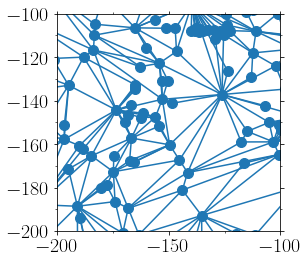

<AxesSubplot:>

In [17]:
ax=utl.PltErr(np.c_[static_graph_tr['nodes']][:,0],
         np.c_[static_graph_tr['nodes']][:,1],
         fmt='.',
        markersize=10,
               Plot=False,
        )
for i,j in zip(static_graph_tr['senders'],static_graph_tr['receivers']):
    x=[static_graph_tr['nodes'][i][0],static_graph_tr['nodes'][j][0]]
    y=[static_graph_tr['nodes'][i][1],static_graph_tr['nodes'][j][1]]
    utl.PltErr(x,y,
               attrs={'fmt':'-','color':'C0'},
               ax=ax,
                  Plot=False,
              )
    

utl.PltErr(None,None,ax=ax,
            xlim=(-200,-100),
            ylim=(-200,-100),
            title='png/graph.png'
          )

### nodes and edges

In [18]:
def get_cmap(n):
    colors = [(1,1,1)] + [(np.random.random(),np.random.random(),np.random.random()) for i in range(n-1)]
    new_map = matplotlib.colors.LinearSegmentedColormap.from_list('new_map', colors, N=n)
    return new_map

new_map = get_cmap(test_data_grains.shape[0])

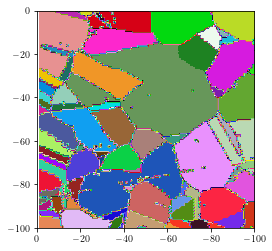

In [19]:
new_map = get_cmap(test_data_grains.shape[0])
#--- plott grains
id_matrix = np.loadtxt('%s/../id_matrix.txt'%confParser['test data files']['load_depth_path'],
          )
n=id_matrix.T.shape[1]
val=np.array([id_matrix.T[:,(n-1)-j] for j in range(n)])
points=np.c_[test_data_grains[['x','y']]]
[xlo,xhi]=[points[:,0].min(),points[:,0].max()]
[ylo,yhi]=[points[:,1].min(),points[:,1].max()]
plot_bitmap = True
if not plot_bitmap:
    val[:,:]=0
plt.imshow(val.T,
        #            id_matrix,
                    origin='lower',
                    extent = (yhi,ylo,xlo,xhi),
        #               extent = (0,-100,-100,0),
                    cmap=new_map
                  )

#--- plot centers
plot_centers=False
pixel_cutoff=64
filtr = test_data_grains['grainSize']>pixel_cutoff
points=np.c_[test_data_grains[filtr][['x','y']]]
xt=points[:,0] 
yt=points[:,1]

#--- plot edges
singlePixel = test_data_grains[test_data_grains['grainSize']<=pixel_cutoff].index
for i,j in zip(static_graph_tr['senders'],static_graph_tr['receivers']):
    if i in singlePixel or j in singlePixel:
        continue
    x=[static_graph_tr['nodes'][i][0],static_graph_tr['nodes'][j][0]]
    y=[static_graph_tr['nodes'][i][1],static_graph_tr['nodes'][j][1]]
    if plot_centers:
        plt.plot(y,x,
                   '-',color='C0',
                 lw=.8,
                  )

if plot_centers:
    plt.plot(yt,
             xt,
             '.',color='black',
             markersize=22,
            )

#--- range
l=h=100
xc=yc=-50
plt.xlim(xc+l/2,xc-l/2)
plt.ylim(yc-h/2,yc+h/2)
plt.savefig('png/gnn.png',bbox_inches='tight',pad_inches=0.0,dpi=600)

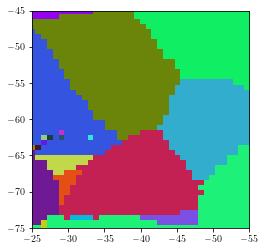

In [20]:
new_map = get_cmap(test_data_grains.shape[0])
#--- plott grains
id_matrix = np.loadtxt('%s/../id_matrix.txt'%confParser['test data files']['load_depth_path'],
          )
n=id_matrix.T.shape[1]
val=np.array([id_matrix.T[:,(n-1)-j] for j in range(n)])
points=np.c_[test_data_grains[['x','y']]]
[xlo,xhi]=[points[:,0].min(),points[:,0].max()]
[ylo,yhi]=[points[:,1].min(),points[:,1].max()]
plot_bitmap = True
if not plot_bitmap:
    val[:,:]=0
plt.imshow(val.T,
        #            id_matrix,
                    origin='lower',
                    extent = (yhi,ylo,xlo,xhi),
        #               extent = (0,-100,-100,0),
                    cmap=new_map
                  )

#--- plot centers
plot_centers=False
pixel_cutoff=64
filtr = test_data_grains['grainSize']>pixel_cutoff
points=np.c_[test_data_grains[filtr][['x','y']]]
xt=points[:,0] 
yt=points[:,1]

#--- plot edges
singlePixel = test_data_grains[test_data_grains['grainSize']<=pixel_cutoff].index
for i,j in zip(static_graph_tr['senders'],static_graph_tr['receivers']):
    if i in singlePixel or j in singlePixel:
        continue
    x=[static_graph_tr['nodes'][i][0],static_graph_tr['nodes'][j][0]]
    y=[static_graph_tr['nodes'][i][1],static_graph_tr['nodes'][j][1]]
    if plot_centers:
        plt.plot(y,x,
                   '-',color='C0',
                 lw=.8,
                  )

if plot_centers:
    plt.plot(yt,
             xt,
             '.',color='black',
             markersize=22,
            )

#--- range
l=h=30
xc=-40;yc=-60
plt.xlim(xc+l/2,xc-l/2)
plt.ylim(yc-h/2,yc+h/2)
plt.savefig('png/gnnMagnified.png',bbox_inches='tight',pad_inches=0.0,dpi=600)

### plot indented grains

In [21]:
mask = np.all(np.isnan(predictors),axis=1)
grainID_notindented = np.c_[test_data_grains[mask]['#grainID']].astype(int)

mask called


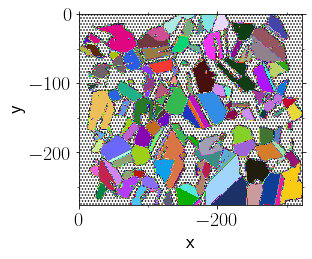

In [199]:
class PlotGrains:
    def __init__(self,id_matrix):
    
        self.id_matrix = id_matrix #--- grain-id matrix 
        
    def reshape(self,grain_ids,val):
        self.val=np.zeros(self.id_matrix.shape[0]*self.id_matrix.shape[1]).\
        reshape((self.id_matrix.shape[0],self.id_matrix.shape[1]))
        for grainID in grain_ids:
            h=val[grain_ids==grainID][0]
            self.val[self.id_matrix==grainID]=h        

    def Bounds(self,points):
        [self.xlo,self.xhi]=[points[:,0].min(),points[:,0].max()]
        [self.ylo,self.yhi]=[points[:,1].min(),points[:,1].max()]

    def Mask(self,grainID_notindented):
        for grain_id in grainID_notindented.flatten(): #--- not show indented grains
                self.id_matrix[self.id_matrix == grain_id]=0
        
    def MaskField(self,grainID_notindented):
        for grain_id in grainID_notindented.flatten(): #--- not show indented grains
                self.val[self.id_matrix == grain_id] = np.nan

    def Transform(self):
        n=self.id_matrix.T.shape[1]
        self.id_matrix =np.array([self.id_matrix.T[:,(n-1)-j] for j in range(n)]) #--- transform
        
    def TransformField(self):
        n=self.val.T.shape[1]
        self.val = np.array([self.val.T[:,(n-1)-j] for j in range(n)]) #--- transform

        
    def PlotOrientation(self):
        new_map = get_cmap(len(set(self.id_matrix.flatten())))
        utl.PltBitmap(self.id_matrix.T,
                   xlim = (self.yhi,self.ylo),ylim = (self.xlo,self.xhi),
#                    xlabel='',ylabel='',
                      zscore=False,
                    cmap=new_map,
                    mask = self.id_matrix.T == 0,
                    title='png/indented2nd.png',
#                       Plot=True
                  )
    def PlotOrientationSingle(self,**kwargs):
        new_map = get_cmap(len(set(self.id_matrix.flatten())))
#         print(self.__dict__)
        utl.PltBitmap(self.id_matrix.T,
                   xlim = (self.yhi,self.ylo),ylim = (self.xlo,self.xhi),
                    xlabel='',ylabel='',
                      zscore=False,
                    cmap=new_map,
#                    mask = self.id_matrix.T == 0,
                    **kwargs
#                    title='png/indented2nd.png'
                  )

    def PlotField(self,**kwargs):
#        print('kwargs:',kwargs)
        utl.PltBitmap(self.val.T,
        #            id_matrix,
#                    origin='lower',
                      xlabel='',ylabel='',
                    xlim = (self.yhi,self.ylo),
                    ylim = (self.xlo,self.xhi),
                      zscore=False,
                      colorbar=True,
                    **kwargs
                  )
        
    def sub_matrix(self):
        (rows,cols)=self.id_matrix.nonzero() #--- associated with single grain
        filtr=~np.isnan(self.id_matrix[rows,cols]) #--- throw nans
        #--- bounds
        row_min = rows[filtr].min()
        row_max = rows[filtr].max()
        col_min = cols[filtr].min()
        col_max = cols[filtr].max()
        #--- xy bounds
        xmax = (1.0*col_max/self.id_matrix.shape[1])*(self.xhi-self.xlo)+self.xlo
        xmin = (1.0*col_min/self.id_matrix.shape[1])*(self.xhi-self.xlo)+self.xlo
        ymax = (1.0*row_max/self.id_matrix.shape[0])*(self.ylo-self.yhi)+self.yhi
        ymin = (1.0*row_min/self.id_matrix.shape[0])*(self.ylo-self.yhi)+self.yhi
        self.xhi=xmax
        self.xlo=xmin
        self.yhi=ymax
        self.ylo=ymin

        #--- sub matrix
        self.id_matrix = self.id_matrix[row_min:row_max,col_min:col_max]
    
    

        

plott = PlotGrains( np.loadtxt('%s/../id_matrix.txt'%confParser['test data files']['load_depth_path']) #--- bitmap of grain ids
                  )
plott.Bounds(np.c_[test_data_grains[['x','y']]])
plott.Transform()
plott.Mask(grainID_notindented)
plott.PlotOrientation()



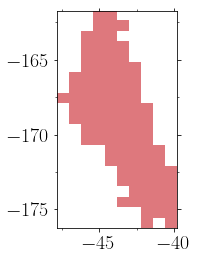

In [200]:
#--- mask every grain_indx != GrainIndex
GrainIndex=10
mask = np.zeros(test_data_grains.shape[0],dtype=bool)
mask[GrainIndex]=True
grainID_masked = np.c_[test_data_grains[~mask]['#grainID']].astype(int)

#--- plot
plott = PlotGrains( np.loadtxt('%s/../id_matrix.txt'%confParser['test data files']['load_depth_path']) #--- bitmap of grain ids
                  )
plott.Bounds(np.c_[test_data_grains[['x','y']]])
#
plott.Transform()
#
plott.Mask(grainID_masked)
#
plott.sub_matrix()
#
plott.PlotOrientationSingle()

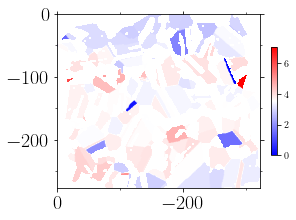

In [56]:

# h_mat=np.zeros(id_matrix.shape[0]*id_matrix.shape[1]).reshape((id_matrix.shape[0],id_matrix.shape[1]))
# h_mat.shape
# for grainID in test_data_grains['#grainID']:
#     h=test_data_grains[test_data_grains['#grainID']==grainID].iloc[0]['h(Gpa)']
#     h_mat[id_matrix==grainID]=h

    
plott = PlotGrains( np.loadtxt('%s/../id_matrix.txt'%confParser['test data files']['load_depth_path']),
                  )
plott.reshape( np.c_[test_data_grains['#grainID']],np.c_[test_data_grains['h(Gpa)']])
plott.Bounds(np.c_[test_data_grains[['x','y']]])
plott.Transform()
plott.TransformField()
plott.MaskField(grainID_notindented)
plott.Mask(grainID_notindented)
plott.PlotField(cmap='bwr')


# Train

In [158]:
from sklearn.base import BaseEstimator
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted


class GnnRegressor(BaseEstimator):

    def __init__(self, **kwargs):
#        print('constructor call')
        for key, val in kwargs.items():
            setattr(self,key,val)
        #        self.param = kwargs
        # Create the model.
        self.model = EncodeProcessDecode(node_output_size=self.node_output_size)
        
    def fit(self, X, y):

        # Check that X and y have correct shape
        X, y = check_X_y(X, y,multi_output=True)
        # Store the classes seen during fit
    #         self.classes_ = unique_labels(y)

        self.X_ = X
        self.y_ = y
    #         # Return the classifier
        return self

    def predict(self, X):
#         # Check if fit has been called
#        check_is_fitted(self)

        #         # Input validation
        X = check_array(X)

        #--- training base graph
        output_ops, latent_ops = self.model(self.input_graph, self.num_processing_steps_tr)

        # Training loss.
        loss_op_tr = []
        loss_op_va = []
        loss_op_ts = []
        corr_op_tr = []
        corr_op_va = []
        corr_op_ts = []

        for op in output_ops:
            loss_op_tr.append( create_loss_ops(self.target_nodes, op, self.train_mask,self.weight))
            loss_op_va.append( create_loss_ops(self.target_nodes, op, self.val_mask,self.weight))
            loss_op_ts.append( create_loss_ops(self.target_nodes, op, self.test_mask,self.weight))
            corr_op_tr.append( create_corr_ops(self.target_nodes, op, self.train_mask))
            corr_op_va.append( create_corr_ops(self.target_nodes, op, self.val_mask))
            corr_op_ts.append( create_corr_ops(self.target_nodes, op, self.test_mask))

        # Training loss across processing steps.
        loss_op_tr_sum = sum(loss_op_tr) / self.num_processing_steps_tr


        # Optimizer.
        optimizer = tf.train.AdamOptimizer(self.learning_rate)
        step_op = optimizer.minimize(loss_op_tr_sum)


        training_history = np.zeros((self.num_training_iterations, 3*self.num_processing_steps_tr)) 
        correlat_history = np.zeros((self.num_training_iterations, 3*self.num_processing_steps_tr)) 
        counter = 0


        # This cell resets the Tensorflow session, but keeps the same computational
        # graph.
        try:
          sess.close()
        except NameError:
          pass
        sess = tf.Session()
        sess.run(tf.global_variables_initializer())
#        pdb.set_trace()
        print(snt.format_variables(self.model.variables))

        best_corr = np.zeros((self.num_processing_steps_tr,3))
        best_val_loss = np.inf
        best_corr_loss = 0.0
        best_val_loss_all = np.inf*np.ones(self.num_processing_steps_tr)
        best_corr_loss_all = np.zeros(self.num_processing_steps_tr)
        last_improved = 0
        early_stopping_crit = self.num_training_iterations

        measure_val_by_loss= True
        print("MEASURE VALIDATION BY LOSS ", measure_val_by_loss)

        # #--- training loop
        t0 = time.time()
        for iteration in range(self.num_training_iterations):
            last_iteration = iteration
            train_values = sess.run({
                "step": step_op,
                "loss": loss_op_tr,
                "outputs": output_ops,
                "latents": latent_ops,
                "corr": corr_op_tr

            })


            test_values = sess.run({
                "loss_val":  loss_op_va,
                "loss_test": loss_op_ts,
                    "corr_val": corr_op_va,
                    "corr_test": corr_op_ts
            })
            
            #--- store losses at each iteration: training_history[counter]=[train_loss,val_loss,test_loss]
            training_history[counter, 0:self.num_processing_steps_tr] = train_values['loss']
            training_history[counter, self.num_processing_steps_tr:2*self.num_processing_steps_tr] = test_values['loss_val']
            training_history[counter, 2*self.num_processing_steps_tr:] = test_values['loss_test']

            correlat_history[counter, 0:self.num_processing_steps_tr] = np.median(train_values['corr'])
            correlat_history[counter, self.num_processing_steps_tr:2*self.num_processing_steps_tr] = np.median(test_values['corr_val'])
            correlat_history[counter, 2*self.num_processing_steps_tr:] = np.median(test_values['corr_test'])


            #--- print loss corresponding to the last block
            if(iteration+1) %100==0:
                print("%s, training %3.2e, validation %3.2e, test %3.2e, best loss %3.2e"
                      %(iteration+1,training_history[counter,self.num_processing_steps_tr-1], 
                        training_history[counter,2*self.num_processing_steps_tr-1],training_history[counter,-1], best_val_loss ))

                for i in range(self.num_processing_steps_tr):
                    if measure_val_by_loss:
                        cond =      (training_history[counter,0*self.num_processing_steps_tr+i] < best_val_loss_all[i]) #--- training
                        cond_best = (training_history[counter,0*self.num_processing_steps_tr+i] < best_val_loss)
        #             else:
        #                 cond =  (correlat_history[counter,num_processing_steps_tr+i] > best_corr_loss_all[i])
        #                 cond_best = (correlat_history[counter,num_processing_steps_tr+i] > best_corr_loss)
                    if cond:
                        step_output =  sess.run(output_ops[i].nodes) # sess.run(output_ops)	
        #                step_outputt[i] =  np.copy(sess.run(output_ops[i].nodes)) # sess.run(output_ops)	
        #                 pdb.set_trace()
                        best_corr[i,0] = stats.pearsonr( step_output[train_mask_np].flatten(),  np.array(target_nodes_np)[train_mask_np].flatten() )[0]
                        best_corr[i,1] = stats.pearsonr( step_output[val_mask_np].flatten(),   np.array(target_nodes_np)[val_mask_np].flatten() )[0]
                        best_corr[i,2] = stats.pearsonr( step_output[test_mask_np].flatten(),   np.array(target_nodes_np)[test_mask_np].flatten() )[0]
                        #print("      best val res, r: training {:.4f}, validation {:.4f}, test {:.4f}".format( best_corr[0], best_corr[1], best_corr[2]  ))

                        best_val_loss_all[i] = training_history[counter,0*self.num_processing_steps_tr+i] #--- training
                        best_corr_loss_all[i] = correlat_history[counter,0*self.num_processing_steps_tr+i]
                    if cond_best:
                        assert cond
                        best_output = np.copy(step_output)
                        best_latent = sess.run(latent_ops[i])
                        #print(best_latent.shape)
        #                    best_val_loss = training_history[counter,num_processing_steps_tr+i] #--- validation
        #                    best_corr_loss = correlat_history[counter,num_processing_steps_tr+i]
                        #
        #                 print('best condition met, loss_old=%3.2e'%best_val_loss)
                        best_val_loss = training_history[counter,0*self.num_processing_steps_tr+i] #--- test
        #                 print('best condition met, loss_new=%3.2e'%best_val_loss)
                        best_corr_loss = correlat_history[counter,0*self.num_processing_steps_tr+i]
                        last_improved = counter


            counter+=1 
            if counter > last_improved + early_stopping_crit:
                print('NO IMPROVEMENT IN {} STEPS, STOPPING TRAINING...'.format(int(early_stopping_crit)))
                break


#        f_label = "{}_{}_{}{}".format(pure_lab, learning_rate,num_processing_steps_tr,data_split_lab)

        training_history = training_history[:counter]
        correlat_history = correlat_history[:counter]
        for i in range(self.num_processing_steps_tr):
            print("    %s steps:  best val res, r: training %6.5e, validation %6.5e, test %6.5e"%(i+1, best_corr[i,0], best_corr[i,1], best_corr[i,2]  ))
            latest_output =  sess.run(output_ops[i].nodes) # sess.run(output_ops)	
        #     np.savetxt("/scratch/work/salmenh1/gnn/training_results_deepmind/graphnet_all_proc_latest_pred_{}_{}.dat".format(f_label,i+1), latest_output)



        # np.savetxt(   "/scratch/work/salmenh1/gnn/training_results_deepmind/graphnet_all_proc_training_history_{}.dat".format(f_label), training_history)
        # np.savetxt("/scratch/work/salmenh1/gnn/training_results_deepmind/graphnet_all_proc_correlation_history_{}.dat".format(f_label), correlat_history)
        # np.savetxt(          "/scratch/work/salmenh1/gnn/training_results_deepmind/graphnet_all_proc_best_pred_{}.dat".format(f_label), best_output)
        # np.save(           "/scratch/work/salmenh1/gnn/training_results_deepmind/graphnet_all_proc_best_latent_{}.npy".format(f_label), best_latent)
        print('elapsed times:%ss'%(time.time()-t0))

        #         closest = np.argmin(euclidean_distances(X, self.X_), axis=1)
        return best_output, training_history #self.y_[closest]
    
    def mse(self,y_act,y_pred):
        return mean_squared_error(y_act,y_pred)
    


## train-test

In [161]:
if eval(confParser['flags']['train_test']):
    gnnReg = GnnRegressor(
                            num_processing_steps_tr = eval(confParser['Parameters']['num_processing_steps_tr']),
                            num_training_iterations = eval(confParser['Parameters']['num_training_iterations']), 
                            learning_rate = eval(confParser['Parameters']['learning_rate']),
                            input_graph=input_graph,
                            node_output_size = len(target_nodes_np[0]),
                            train_mask = tf.constant(train_mask_np, dtype=tf.bool),
                            test_mask  = tf.constant(test_mask_np , dtype=tf.bool),
                            val_mask   = tf.constant(val_mask_np  , dtype=tf.bool),
                            target_nodes = tf.constant(target_nodes_np),
                            weight = None )

    gnnReg.fit( np.array(static_graph_tr['nodes'])[train_mask_np],
                np.array(target_nodes_np)[train_mask_np] )

    best_output, training_history = gnnReg.predict(np.array(static_graph_tr['nodes']))

    mse_test = gnnReg.mse(np.array(target_nodes_np)[test_mask_np].flatten(),
                np.array(best_output[test_mask_np]).flatten())
    mse_train = gnnReg.mse(np.array(target_nodes_np)[train_mask_np].flatten(),
                np.array(best_output[train_mask_np]).flatten())
    !mkdir mse
    np.savetxt('mse/validation.txt',
               np.c_[mse_test,mse_train],
               header='test\ttrain')

Variable                                                               Shape  Type     Collections                            Device
EncodeProcessDecode_4/graph_independent/node_model/node_output/b       100    float32  global_variables, trainable_variables  (legacy)
EncodeProcessDecode_4/graph_independent/node_model/node_output/w       8x100  float32  global_variables, trainable_variables  (legacy)
MLPGraphIndependent_8/graph_independent/edge_model/layer_norm/beta     8      float32  global_variables, trainable_variables  (legacy)
MLPGraphIndependent_8/graph_independent/edge_model/layer_norm/gamma    8      float32  global_variables, trainable_variables  (legacy)
MLPGraphIndependent_8/graph_independent/edge_model/mlp/linear_0/b      8      float32  global_variables, trainable_variables  (legacy)
MLPGraphIndependent_8/graph_independent/edge_model/mlp/linear_0/w      1x8    float32  global_variables, trainable_variables  (legacy)
MLPGraphIndependent_8/graph_independent/edge_model/mlp/li

700, training 2.82e+04, validation 2.39e+04, test 2.39e+04, best loss 2.96e+04
800, training 2.68e+04, validation 2.25e+04, test 2.25e+04, best loss 2.82e+04
900, training 2.53e+04, validation 2.10e+04, test 2.10e+04, best loss 2.68e+04
1000, training 2.38e+04, validation 1.95e+04, test 1.95e+04, best loss 2.53e+04
1100, training 2.23e+04, validation 1.80e+04, test 1.80e+04, best loss 2.38e+04
1200, training 2.08e+04, validation 1.66e+04, test 1.66e+04, best loss 2.23e+04
1300, training 1.93e+04, validation 1.51e+04, test 1.51e+04, best loss 2.08e+04
1400, training 1.79e+04, validation 1.38e+04, test 1.38e+04, best loss 1.93e+04
1500, training 1.66e+04, validation 1.25e+04, test 1.25e+04, best loss 1.79e+04
1600, training 1.54e+04, validation 1.13e+04, test 1.13e+04, best loss 1.66e+04
1700, training 1.43e+04, validation 1.02e+04, test 1.02e+04, best loss 1.54e+04
1800, training 1.32e+04, validation 9.23e+03, test 9.23e+03, best loss 1.43e+04
1900, training 1.23e+04, validation 8.36e+0

11000, training 3.45e+02, validation 5.23e+03, test 5.23e+03, best loss 1.93e+02
11100, training 3.31e+02, validation 5.63e+03, test 5.63e+03, best loss 1.93e+02
11200, training 3.17e+02, validation 5.87e+03, test 5.87e+03, best loss 1.93e+02
11300, training 3.06e+02, validation 5.99e+03, test 5.99e+03, best loss 1.93e+02
11400, training 2.98e+02, validation 6.04e+03, test 6.04e+03, best loss 1.93e+02
11500, training 2.91e+02, validation 6.05e+03, test 6.05e+03, best loss 1.93e+02
11600, training 2.85e+02, validation 6.06e+03, test 6.06e+03, best loss 1.93e+02
11700, training 2.82e+02, validation 6.07e+03, test 6.07e+03, best loss 1.93e+02
11800, training 2.75e+02, validation 6.00e+03, test 6.00e+03, best loss 1.93e+02
11900, training 2.73e+02, validation 5.95e+03, test 5.95e+03, best loss 1.93e+02
12000, training 2.69e+02, validation 5.95e+03, test 5.95e+03, best loss 1.93e+02
12100, training 2.67e+02, validation 5.96e+03, test 5.96e+03, best loss 1.93e+02
12200, training 2.68e+02, va

21200, training 6.13e+01, validation 1.19e+03, test 1.19e+03, best loss 6.69e+01
21300, training 6.43e+01, validation 1.22e+03, test 1.22e+03, best loss 6.13e+01
21400, training 6.19e+01, validation 1.18e+03, test 1.18e+03, best loss 6.13e+01
21500, training 6.24e+01, validation 1.20e+03, test 1.20e+03, best loss 6.13e+01
21600, training 5.90e+01, validation 1.17e+03, test 1.17e+03, best loss 6.13e+01
21700, training 6.36e+01, validation 1.11e+03, test 1.11e+03, best loss 5.90e+01
21800, training 5.93e+01, validation 1.10e+03, test 1.10e+03, best loss 5.90e+01
21900, training 6.68e+01, validation 1.09e+03, test 1.09e+03, best loss 5.90e+01
22000, training 6.03e+01, validation 1.10e+03, test 1.10e+03, best loss 5.90e+01
22100, training 6.09e+01, validation 1.09e+03, test 1.09e+03, best loss 5.90e+01
22200, training 6.17e+01, validation 1.04e+03, test 1.04e+03, best loss 5.90e+01
22300, training 5.68e+01, validation 1.05e+03, test 1.05e+03, best loss 5.90e+01
22400, training 6.28e+01, va

## Learning curve

In [125]:
def learning_curve(train_sizes,cv):
    mse={}
    mse_training={}
    for keys in cv:
        full_train_set = cv[keys]['train']
        test_set = cv[keys]['test']
        mse[keys]=[]
        mse_training[keys]=[]
        for fraction in train_sizes:
            partial_set = GetSubset(full_train_set,fraction)
            print('training size=',np.sum(partial_set))
            
            #--- train
            gnnReg = GnnRegressor(
                        num_processing_steps_tr = eval(confParser['Parameters']['num_processing_steps_tr']),
                        num_training_iterations = eval(confParser['Parameters']['num_training_iterations']), 
                        learning_rate = eval(confParser['Parameters']['learning_rate']),
                        input_graph=input_graph,
                        node_output_size = len(target_nodes_np[0]),
                        train_mask = tf.constant(partial_set, dtype=tf.bool),
                        test_mask  = tf.constant(test_set , dtype=tf.bool),
                        val_mask   = tf.constant(test_set  , dtype=tf.bool),
                        target_nodes = tf.constant(target_nodes_np),
                        weight = None )

            gnnReg.fit( np.array(static_graph_tr['nodes'])[partial_set],
                        np.array(target_nodes_np)[partial_set] )

            prediction, _ = gnnReg.predict(np.array(static_graph_tr['nodes']))

            mse[keys].append(mean_squared_error(np.array(target_nodes_np)[test_set].flatten(),
                   np.array(prediction[test_set]).flatten()))
            mse_training[keys].append(mean_squared_error(np.array(target_nodes_np)[partial_set].flatten(),
                   np.array(prediction[partial_set]).flatten()))
    return mse, mse_training



In [126]:
if eval(confParser['flags']['learning_curve']):
    t0=time.time()
    #--- learning curve
    mask = np.all(~np.isnan(predictors),axis=1) #--- indented grains
    train_sizes= [eval(confParser['Parameters']['train_size_learning'])] 
    #np.array([0.1  , 0.325, 0.55 , 0.775, 1.   ]) # np.arange(0.1,1.1,0.1) #
    mse_test, mse_training=learning_curve(train_sizes=train_sizes, 
                   cv=train_test_split(mask,3))
    print('elapsed times:%ss'%(time.time()-t0))

    #--- plot
    #--- test
    yerr = np.std(np.c_[list(map(lambda x:x,mse_test.values()))],axis=0)/np.sqrt(len(mse_test))
    ydata = np.mean(np.c_[list(map(lambda x:x,mse_test.values()))],axis=0)
    #--- training 
    yerr_tr = np.std(np.c_[list(map(lambda x:x,mse_training.values()))],axis=0)/np.sqrt(len(mse_training))
    ydata_tr = np.mean(np.c_[list(map(lambda x:x,mse_training.values()))],axis=0)

    utl.PltErr(train_sizes,ydata,yerr=yerr,
              xstr='size',
               ystr='mse',
              )
    !mkdir mse
    np.savetxt('mse/learning_curve.txt',
               np.c_[train_sizes,ydata,yerr,ydata_tr,yerr_tr],
               header='train_sizes\tmse_test\terr_test\tmse_training\terr_training')

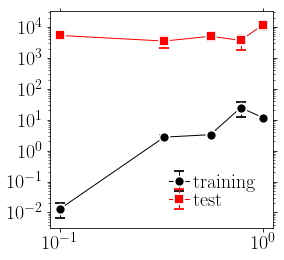

In [9]:
if not eval(confParser['flags']['remote_machine']):
    sdata = np.loadtxt('predictHardnessForcesAddedLearningCurve4th/Run0/mse/learning_curve.txt')

    symbols = utl.Symbols()
    legend=utl.Legends()
    legend.Set()
    ax=utl.PltErr(sdata[:,0],
                  sdata[:,3],
                  yerr=sdata[:,4],
    #              attrs={'fmt':'-','label':'training'},
                  attrs=symbols.GetAttrs(count=0,fmt='-',label=r'$\mathrm{training}$'),
               xscale='log',
               yscale='log',
                  Plot=False,
              )

    utl.PltErr(sdata[:,0],
                  sdata[:,1],
                    yerr=sdata[:,2],
                  attrs=symbols.GetAttrs(count=1,label=r'$\mathrm{test}$'),
#               xscale='log',
               yscale='log',
               ax=ax,
#               xlim=(1,1e6),
#               ylim=(1,1e5),
               legend=legend.Get(),
               title='png/learning_curve.png',
#               DrawFrame=(0.2,0.1,0.15,0.1,0.01)
              )

## learning rate

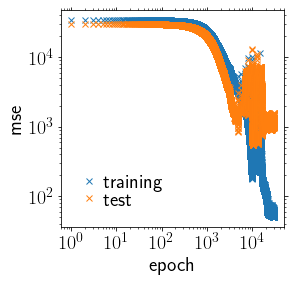

mkdir: cannot create directory ‘mse’: File exists


In [162]:
if eval(confParser['flags']['train_test']):
    iproc=2
    legend=utl.Legends()
    legend.Set()
    num_processing_steps_tr = eval(confParser['Parameters']['num_processing_steps_tr'])
    ax=utl.PltErr(range(training_history.shape[0]),
               training_history[:,0*num_processing_steps_tr+iproc],
               attrs={'fmt':'x','label':'training'},
               xscale='log',
               yscale='log',
                  Plot=False,
              )

    utl.PltErr(range(training_history.shape[0]),
               training_history[:,1*num_processing_steps_tr+iproc],
               attrs={'fmt':'x','label':'test'},
               xscale='log',
               yscale='log',
               ax=ax,
               legend=legend.Get(),
               xstr='epoch',
               ystr='mse',
              )

    !mkdir mse
    np.savetxt('mse/learning_rate.txt',
               np.c_[np.arange(training_history.shape[0])+1,training_history[:,0*num_processing_steps_tr+iproc],training_history[:,1*num_processing_steps_tr+iproc]],
                           header='epoch,training\ttest')

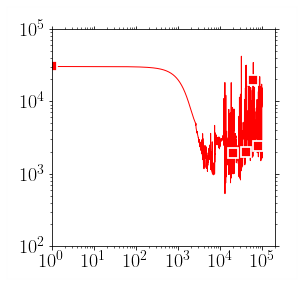

In [18]:
if not eval(confParser['flags']['remote_machine']):
    sdata = np.loadtxt('hardness/Run0/mse/learning_rate.txt')

    symbols = utl.Symbols()
    legend=utl.Legends()
    legend.Set()
    ax=utl.PltErr(None,#sdata[:,0],
                  None,#sdata[:,1],
    #              attrs={'fmt':'-','label':'training'},
                  attrs=symbols.GetAttrs(count=0,fmt='-',label=r'$\mathrm{train}$',nevery=20000),
                  Plot=False,
              )

    utl.PltErr(sdata[:,0],
               sdata[:,2],
                  attrs=symbols.GetAttrs(count=1,label=r'$\mathrm{test}$',nevery=20000),
               xscale='log',
               yscale='log',
               ax=ax,
               xlim=(1,2e5),
               ylim=(1e2,1e5),
#               legend=legend.Get(),
               title='png/learning_rate_test.png',
               DrawFrame=(0.2,0.1,0.15,0.1,0.01)
              )

## validation curve

In [33]:
def GetStat(mse_test):
    mse=np.array(list(mse_test.values())).flatten()
    return mse.mean(), mse.std()

if eval(confParser['flags']['validation_curve']):
    mask = np.all(~np.isnan(predictors),axis=1) #--- indented grains
    mse_test, mse_training=learning_curve(train_sizes=[1.0], 
                   cv=train_test_split(mask,3))
    #
    !mkdir mse
    np.savetxt('mse/validation_curve.txt',
               np.c_[np.c_[GetStat(mse_test),GetStat(mse_training)].flatten()].T,
               header='mse_test\tmse_train\tmse_test_err\tmse_train_err')

training size= 88
Variable                                                               Shape  Type     Collections                            Device
EncodeProcessDecode_1/graph_independent/node_model/node_output/b       100    float32  global_variables, trainable_variables  (legacy)
EncodeProcessDecode_1/graph_independent/node_model/node_output/w       8x100  float32  global_variables, trainable_variables  (legacy)
MLPGraphIndependent_2/graph_independent/edge_model/layer_norm/beta     8      float32  global_variables, trainable_variables  (legacy)
MLPGraphIndependent_2/graph_independent/edge_model/layer_norm/gamma    8      float32  global_variables, trainable_variables  (legacy)
MLPGraphIndependent_2/graph_independent/edge_model/mlp/linear_0/b      8      float32  global_variables, trainable_variables  (legacy)
MLPGraphIndependent_2/graph_independent/edge_model/mlp/linear_0/w      1x8    float32  global_variables, trainable_variables  (legacy)
MLPGraphIndependent_2/graph_independent

700, training 2.72e+04, validation 2.57e+04, test 2.57e+04, best loss 2.86e+04
800, training 2.58e+04, validation 2.43e+04, test 2.43e+04, best loss 2.72e+04
900, training 2.44e+04, validation 2.28e+04, test 2.28e+04, best loss 2.58e+04
1000, training 2.29e+04, validation 2.12e+04, test 2.12e+04, best loss 2.44e+04
    1 steps:  best val res, r: training 4.48002e-01, validation 5.33221e-01, test 5.33221e-01
    2 steps:  best val res, r: training 4.48007e-01, validation 5.33228e-01, test 5.33228e-01
    3 steps:  best val res, r: training 4.48007e-01, validation 5.33228e-01, test 5.33228e-01
elapsed times:20.58943819999695s
training size= 88
Variable                                                               Shape  Type     Collections                            Device
EncodeProcessDecode_2/graph_independent/node_model/node_output/b       100    float32  global_variables, trainable_variables  (legacy)
EncodeProcessDecode_2/graph_independent/node_model/node_output/w       8x100  floa

100, training 3.43e+04, validation 2.96e+04, test 2.96e+04, best loss inf
200, training 3.38e+04, validation 2.90e+04, test 2.90e+04, best loss 3.43e+04
300, training 3.30e+04, validation 2.83e+04, test 2.83e+04, best loss 3.38e+04
400, training 3.21e+04, validation 2.74e+04, test 2.74e+04, best loss 3.30e+04
500, training 3.10e+04, validation 2.63e+04, test 2.63e+04, best loss 3.21e+04
600, training 2.98e+04, validation 2.51e+04, test 2.51e+04, best loss 3.10e+04
700, training 2.84e+04, validation 2.38e+04, test 2.38e+04, best loss 2.98e+04
800, training 2.70e+04, validation 2.24e+04, test 2.24e+04, best loss 2.84e+04
900, training 2.55e+04, validation 2.10e+04, test 2.10e+04, best loss 2.70e+04
1000, training 2.40e+04, validation 1.95e+04, test 1.95e+04, best loss 2.55e+04
    1 steps:  best val res, r: training 4.60773e-01, validation 5.48004e-01, test 5.48004e-01
    2 steps:  best val res, r: training 4.60770e-01, validation 5.48002e-01, test 5.48002e-01
    3 steps:  best val res

100, training 3.07e+04, validation 3.65e+04, test 3.65e+04, best loss inf
200, training 3.02e+04, validation 3.60e+04, test 3.60e+04, best loss 3.07e+04
300, training 2.94e+04, validation 3.52e+04, test 3.52e+04, best loss 3.02e+04
400, training 2.84e+04, validation 3.43e+04, test 3.43e+04, best loss 2.94e+04
500, training 2.73e+04, validation 3.32e+04, test 3.32e+04, best loss 2.84e+04
600, training 2.61e+04, validation 3.20e+04, test 3.20e+04, best loss 2.73e+04
700, training 2.47e+04, validation 3.07e+04, test 3.07e+04, best loss 2.61e+04
800, training 2.33e+04, validation 2.92e+04, test 2.92e+04, best loss 2.47e+04
900, training 2.18e+04, validation 2.78e+04, test 2.78e+04, best loss 2.33e+04
1000, training 2.03e+04, validation 2.63e+04, test 2.63e+04, best loss 2.18e+04
    1 steps:  best val res, r: training 4.52776e-01, validation 5.38723e-01, test 5.38723e-01
    2 steps:  best val res, r: training 4.52776e-01, validation 5.38722e-01, test 5.38722e-01
    3 steps:  best val res

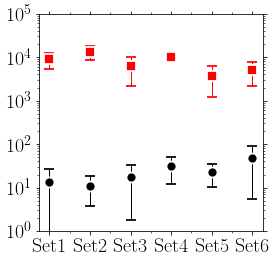

In [4]:
if not eval(confParser['flags']['remote_machine']):
    symbols=utl.Symbols()
    #
    legend=utl.Legends()
    legend.Set(bbox_to_anchor=(0.0,0.5,0.5,0.5))

    ax = utl.PltErr(None,None,Plot=False)

    nmodel=6
    for imodel in range(nmodel):
        mse_train_test = np.loadtxt('validation%s/Run0/mse/validation_curve.txt'%imodel)

        utl.PltErr([imodel],[mse_train_test[1]],
                   yerr=[mse_train_test[3]],
                   ax=ax,
                   attrs=symbols.GetAttrs(count=0,label=r'$\mathrm{Train}$' if imodel == 0 else ''),
                   Plot=False)
        utl.PltErr([imodel],[mse_train_test[0]],
                   yerr=[mse_train_test[2]],
                    attrs=symbols.GetAttrs(count=1,label=r'$\mathrm{Test}$' if imodel == 0 else ''),
                   ax=ax,Plot=False)

    utl.PltErr(None,None,
               yscale='log',
#               legend=legend.Get(),
               title = 'mse/validation_curve.png',
               ylim=(1,1e5),
               xticks=(['$\mathrm{Set}1$','$\mathrm{Set}2$','$\mathrm{Set}3$','$\mathrm{Set}4$','$\mathrm{Set}5$','$\mathrm{Set}6$'],
                       [0,1,2,3,4,5]),
               ax=ax)

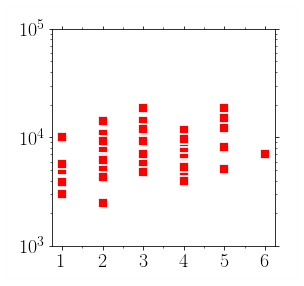

In [26]:
if not eval(confParser['flags']['remote_machine']):
    symbols=utl.Symbols()
    #
    legend=utl.Legends()
    legend.Set(bbox_to_anchor=(0.0,0.5,0.5,0.5))

    ax = utl.PltErr(None,None,Plot=False)

    nmodel=63
    for imodel in range(nmodel):
#         print(imodel)
        mse_train_test = np.loadtxt('model_validation%s/Run0/mse/validation_curve.txt'%imodel)
        #--- subset size
        confParser0 = configparser.ConfigParser()
        confParser0.read('model_validation%s/Run0/config.ini'%imodel)
        p=len(confParser0['Parameters']['attributes'].split())
#         if p==2 and confParser0['Parameters']['attributes']=='x y':
#             print(confParser0['Parameters']['attributes'])
#         else:
#             continue
                
        #
#         utl.PltErr([p],[mse_train_test[1]],
# #                   yerr=[mse_train_test[3]],
#                    ax=ax,
#                    attrs=symbols.GetAttrs(count=0,label=r'$\mathrm{Train}$' if imodel == 0 else ''),
#                    Plot=False)
        utl.PltErr([p],[mse_train_test[0]],
#                   yerr=[mse_train_test[2]],
                    attrs=symbols.GetAttrs(count=1,label=r'$\mathrm{Test}$' if imodel == 0 else ''),
                   ax=ax,Plot=False)

    utl.PltErr(None,None,
               yscale='log',
#               legend=legend.Get(),
               title = 'mse/validation_curve_test.png',
               ylim=(1e3,1e5),
#               ylim=(1e1,1e3),
               xticks=(['$1$','$2$','$3$','$4$','$5$','$6$'],[1,2,3,4,5,6]),
               DrawFrame=(0.2,0.1,0.15,0.1,0.01),
               ax=ax)

In [165]:
# #--- set parameters
# #SEED =1 #44416664
# num_processing_steps_tr = eval(confParser['Parameters']['num_processing_steps_tr']) #3
# #--- Data / training parameters.
# num_training_iterations = eval(confParser['Parameters']['num_training_iterations']) #20000 #8000 #000#0 #20000
# learning_rate = eval(confParser['Parameters']['learning_rate']) #1e-2/4 #7.5e-6

# #np.random.seed(SEED)
# #tf.set_random_seed(SEED)
# #tf.random.set_seed(SEED)

# train_mask = tf.constant(train_mask_np, dtype=tf.bool)
# test_mask  = tf.constant(test_mask_np , dtype=tf.bool)
# val_mask   = tf.constant(val_mask_np  , dtype=tf.bool)

# target_nodes = tf.constant(target_nodes_np)
# weight = tf.constant(weight_np)
# weight = None ##NOTE comment out if weights wanted 


# # Create the model.
# node_output_size = len(target_nodes_np[0])
# model = EncodeProcessDecode(node_output_size=node_output_size)
# #print(model.summary())

# #--- training base graph
# output_ops, latent_ops = model(input_graph, num_processing_steps_tr) #[-1]
# # Training loss.
# loss_op_tr = []
# loss_op_va = []
# loss_op_ts = []
# corr_op_tr = []
# corr_op_va = []
# corr_op_ts = []

# for op in output_ops:
#     loss_op_tr.append( create_loss_ops(target_nodes, op, train_mask,weight))
#     loss_op_va.append( create_loss_ops(target_nodes, op,   val_mask,weight))
#     loss_op_ts.append( create_loss_ops(target_nodes, op,  test_mask,weight))
#     corr_op_tr.append( create_corr_ops(target_nodes, op, train_mask))
#     corr_op_va.append( create_corr_ops(target_nodes, op,   val_mask))
#     corr_op_ts.append( create_corr_ops(target_nodes, op,  test_mask))

# # Training loss across processing steps.
# loss_op_tr_sum = sum(loss_op_tr) / num_processing_steps_tr


# # Optimizer.
# optimizer = tf.train.AdamOptimizer(learning_rate)
# step_op = optimizer.minimize(loss_op_tr_sum)


# training_history = np.zeros((num_training_iterations, 3*num_processing_steps_tr)) 
# correlat_history = np.zeros((num_training_iterations, 3*num_processing_steps_tr)) 
# counter = 0


# # This cell resets the Tensorflow session, but keeps the same computational
# # graph.
# try:
#   sess.close()
# except NameError:
#   pass
# sess = tf.Session()
# sess.run(tf.global_variables_initializer())

# print(snt.format_variables(model.variables))

# best_corr = np.zeros((num_processing_steps_tr,3))
# best_val_loss = np.inf
# best_corr_loss = 0.0
# best_val_loss_all = np.inf*np.ones(num_processing_steps_tr)
# best_corr_loss_all = np.zeros(num_processing_steps_tr)
# last_improved = 0
# early_stopping_crit = num_training_iterations #1000
# step_outputt = [[],[],[]]

# measure_val_by_loss= True
# print("MEASURE VALIDATION BY LOSS ", measure_val_by_loss)

# # #--- training loop
# t0 = time.time()
# for iteration in range(num_training_iterations):
#     last_iteration = iteration
#     train_values = sess.run({
#         "step": step_op,
#         "loss": loss_op_tr,
#         "outputs": output_ops,
#         "latents": latent_ops,
#         "corr": corr_op_tr

#     })
    

#     test_values = sess.run({
#         "loss_val":  loss_op_va,
#         "loss_test": loss_op_ts,
#             "corr_val": corr_op_va,
#             "corr_test": corr_op_ts
#     })
#     training_history[counter, 0:num_processing_steps_tr] = train_values['loss']
#     training_history[counter, num_processing_steps_tr:2*num_processing_steps_tr] = test_values['loss_val']
#     training_history[counter, 2*num_processing_steps_tr:] = test_values['loss_test']

#     correlat_history[counter, 0:num_processing_steps_tr] = np.median(train_values['corr'])
#     correlat_history[counter, num_processing_steps_tr:2*num_processing_steps_tr] = np.median(test_values['corr_val'])
#     correlat_history[counter, 2*num_processing_steps_tr:] = np.median(test_values['corr_test'])



#     if(iteration+1) %100==0:
#         print("%s, training %3.2e, validation %3.2e, test %3.2e, best loss %3.2e"
#               %(iteration+1,training_history[counter,num_processing_steps_tr-1], 
#                 training_history[counter,2*num_processing_steps_tr-1],training_history[counter,-1], best_val_loss ))

#         for i in range(num_processing_steps_tr):
#             if measure_val_by_loss:
# #                cond =      (training_history[counter,num_processing_steps_tr+i] < best_val_loss_all[i]) #--- validation
# #                cond_best = (training_history[counter,num_processing_steps_tr+i] < best_val_loss)
#                 cond =      (training_history[counter,0+i] < best_val_loss_all[i]) #--- training
#                 cond_best = (training_history[counter,0+i] < best_val_loss)
# #             else:
# #                 cond =  (correlat_history[counter,num_processing_steps_tr+i] > best_corr_loss_all[i])
# #                 cond_best = (correlat_history[counter,num_processing_steps_tr+i] > best_corr_loss)
#             if cond:
#                 step_output =  sess.run(output_ops[i].nodes) # sess.run(output_ops)	
# #                step_outputt[i] =  np.copy(sess.run(output_ops[i].nodes)) # sess.run(output_ops)	
# #                 pdb.set_trace()
#                 best_corr[i,0] = stats.pearsonr( step_output[train_mask_np].flatten(),  np.array(target_nodes_np)[train_mask_np].flatten() )[0]
#                 best_corr[i,1] = stats.pearsonr( step_output[val_mask_np].flatten(),   np.array(target_nodes_np)[val_mask_np].flatten() )[0]
#                 best_corr[i,2] = stats.pearsonr( step_output[test_mask_np].flatten(),   np.array(target_nodes_np)[test_mask_np].flatten() )[0]
#                 #print("      best val res, r: training {:.4f}, validation {:.4f}, test {:.4f}".format( best_corr[0], best_corr[1], best_corr[2]  ))

# #                best_val_loss_all[i] = training_history[counter,num_processing_steps_tr+i] #--- validation
# #                best_corr_loss_all[i] = correlat_history[counter,num_processing_steps_tr+i]

#                 best_val_loss_all[i] = training_history[counter,0+i] #--- training
#                 best_corr_loss_all[i] = correlat_history[counter,0+i]
#             if cond_best:
#                 assert cond
#                 best_output = np.copy(step_output)
#                 best_latent = sess.run(latent_ops[i])
#                 #print(best_latent.shape)
# #                    best_val_loss = training_history[counter,num_processing_steps_tr+i] #--- validation
# #                    best_corr_loss = correlat_history[counter,num_processing_steps_tr+i]
#                 #
# #                 print('best condition met, loss_old=%3.2e'%best_val_loss)
#                 best_val_loss = training_history[counter,0+i] #--- training
# #                 print('best condition met, loss_new=%3.2e'%best_val_loss)
#                 best_corr_loss = correlat_history[counter,0+i]
#                 last_improved = counter
                    

#     counter+=1 
#     if counter > last_improved + early_stopping_crit:
#         print('NO IMPROVEMENT IN {} STEPS, STOPPING TRAINING...'.format(int(early_stopping_crit)))
#         break


# f_label = "{}_{}_{}{}".format(pure_lab, learning_rate,num_processing_steps_tr,data_split_lab)

# training_history = training_history[:counter]
# correlat_history = correlat_history[:counter]
# for i in range(num_processing_steps_tr):
#     print("    %s steps:  best val res, r: training %6.5e, validation %6.5e, test %6.5e"%(i+1, best_corr[i,0], best_corr[i,1], best_corr[i,2]  ))
#     latest_output =  sess.run(output_ops[i].nodes) # sess.run(output_ops)	
# #     np.savetxt("/scratch/work/salmenh1/gnn/training_results_deepmind/graphnet_all_proc_latest_pred_{}_{}.dat".format(f_label,i+1), latest_output)



# # np.savetxt(   "/scratch/work/salmenh1/gnn/training_results_deepmind/graphnet_all_proc_training_history_{}.dat".format(f_label), training_history)
# # np.savetxt("/scratch/work/salmenh1/gnn/training_results_deepmind/graphnet_all_proc_correlation_history_{}.dat".format(f_label), correlat_history)
# # np.savetxt(          "/scratch/work/salmenh1/gnn/training_results_deepmind/graphnet_all_proc_best_pred_{}.dat".format(f_label), best_output)
# # np.save(           "/scratch/work/salmenh1/gnn/training_results_deepmind/graphnet_all_proc_best_latent_{}.npy".format(f_label), best_latent)
# print('elapsed times:%ss'%(time.time()-t0))

In [497]:
# i=1
# step_output =  sess.run(output_ops[i].nodes)
# best_output = np.copy(step_output)

In [498]:
# with sess.as_default():
#     print(output_ops[0].receivers.eval().shape)

## predictions
### training set

grain_indx= 0


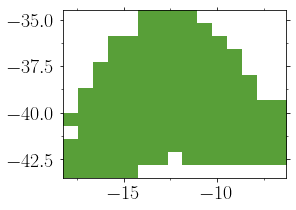

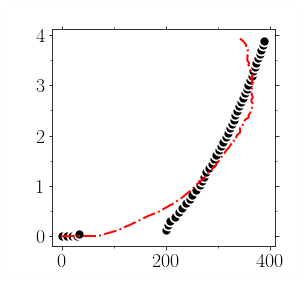

grain_indx= 1


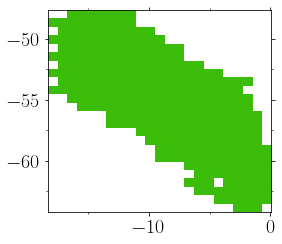

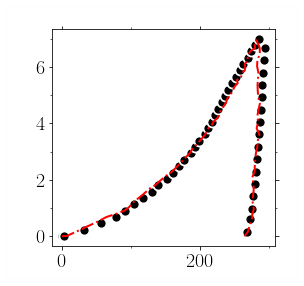

grain_indx= 3


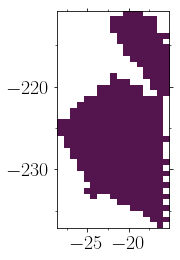

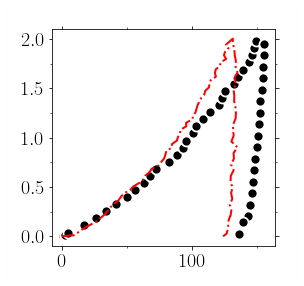

grain_indx= 4


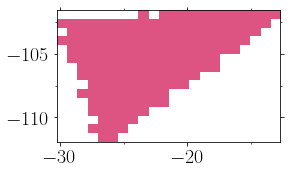

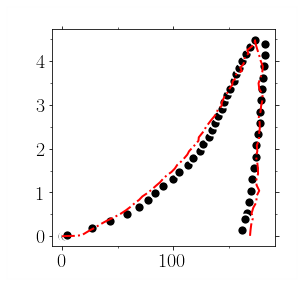

grain_indx= 5


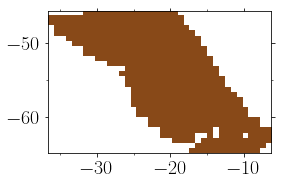

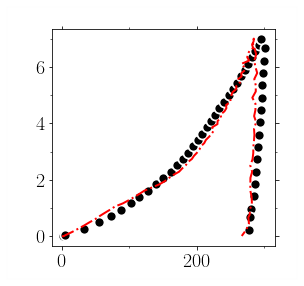

grain_indx= 6


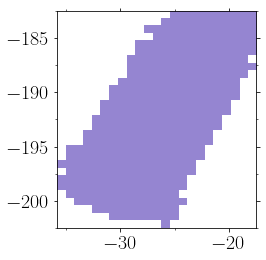

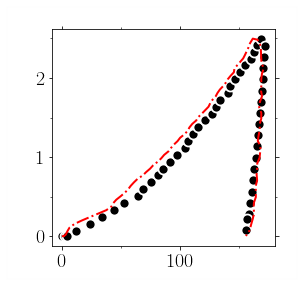

grain_indx= 7


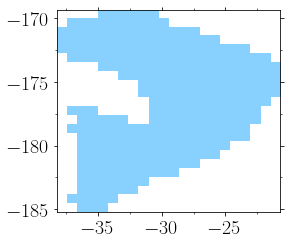

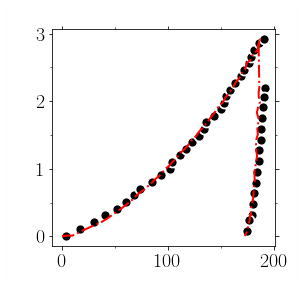

grain_indx= 9


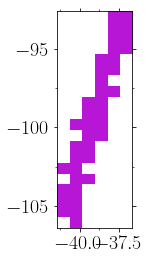

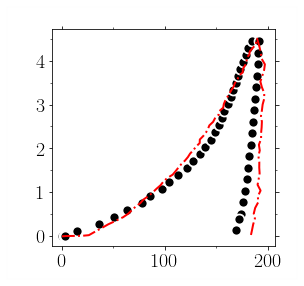

grain_indx= 10


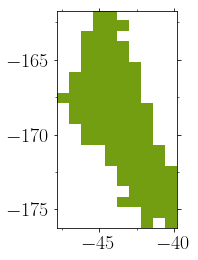

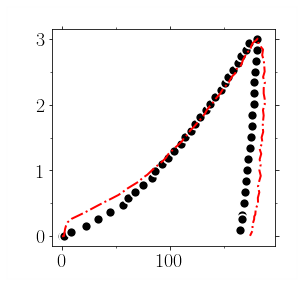

grain_indx= 12


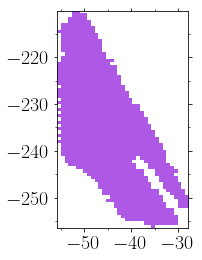

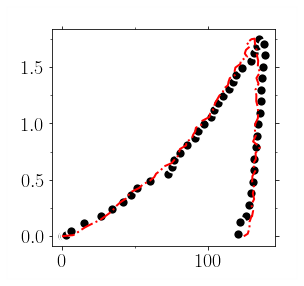

grain_indx= 15


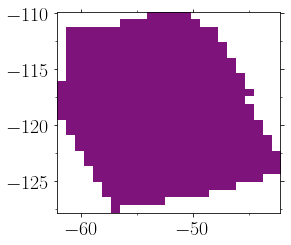

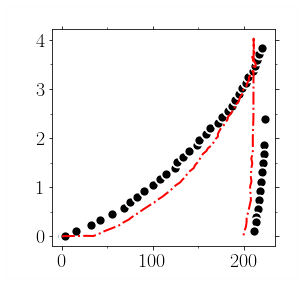

grain_indx= 16


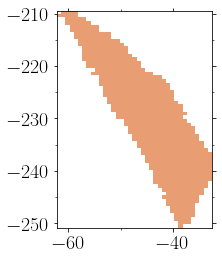

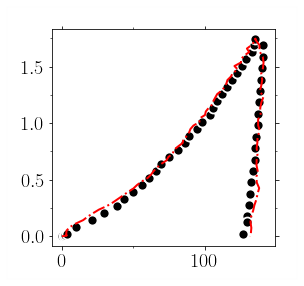

grain_indx= 17


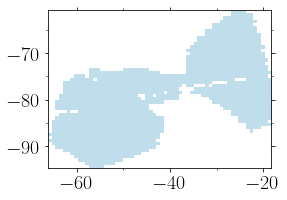

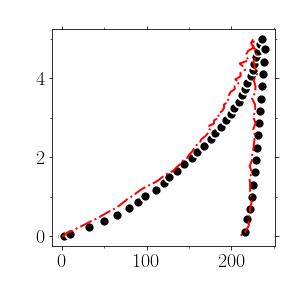

grain_indx= 19


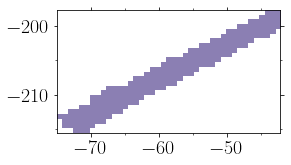

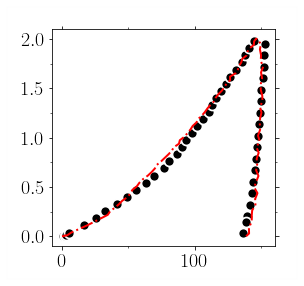

grain_indx= 20


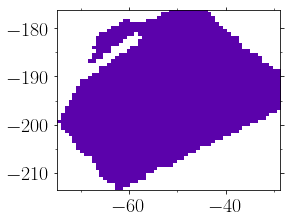

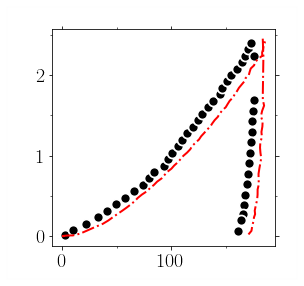

grain_indx= 21


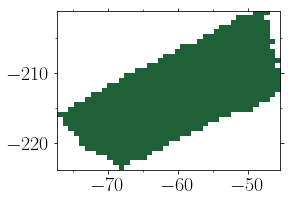

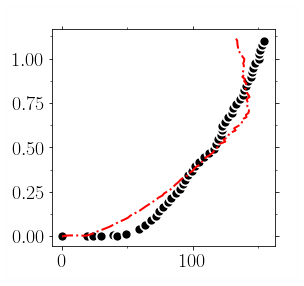

grain_indx= 22


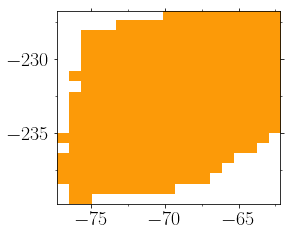

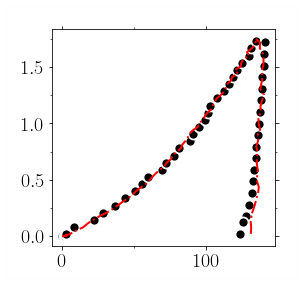

grain_indx= 23


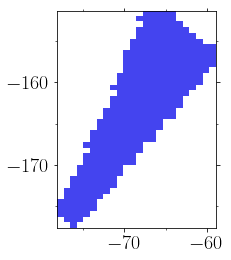

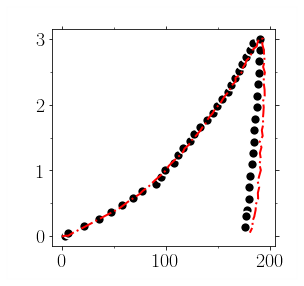

grain_indx= 25


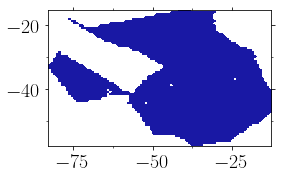

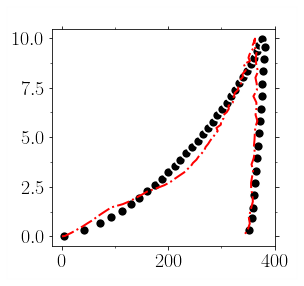

grain_indx= 27


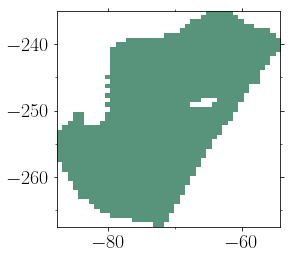

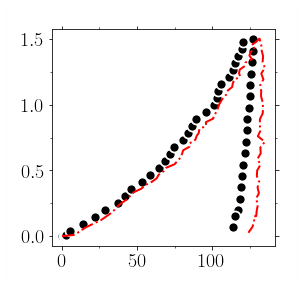

grain_indx= 29


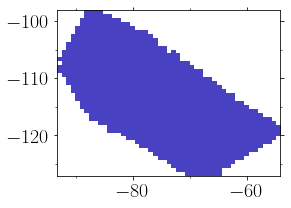

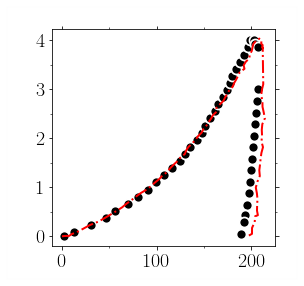

grain_indx= 30


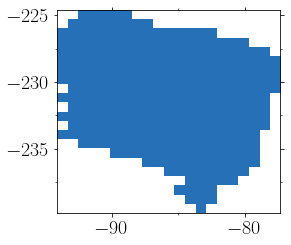

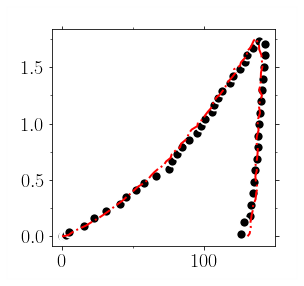

grain_indx= 34


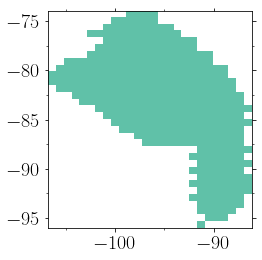

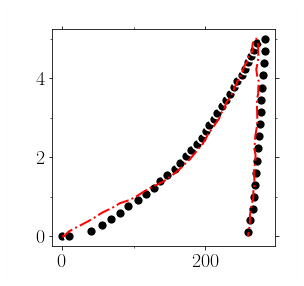

grain_indx= 35


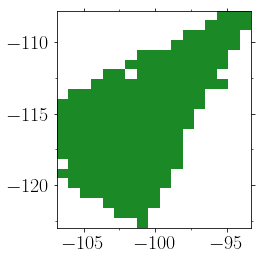

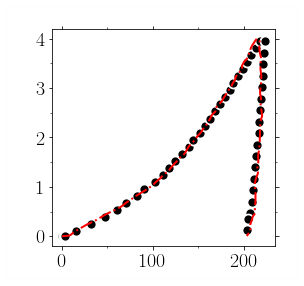

grain_indx= 36


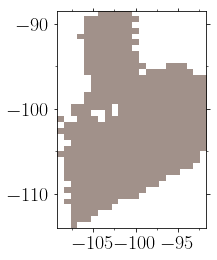

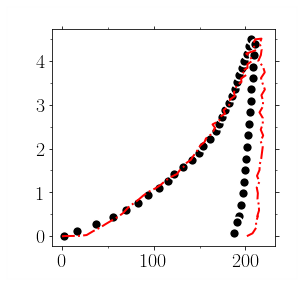

grain_indx= 39


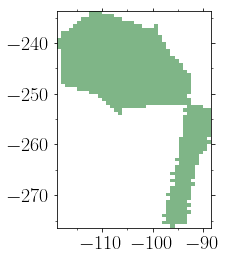

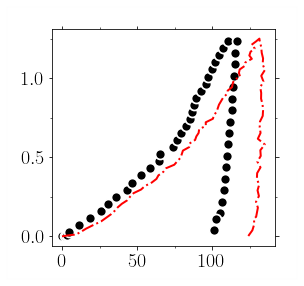

grain_indx= 40


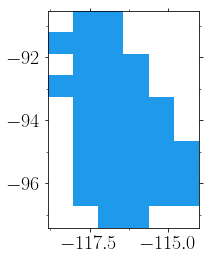

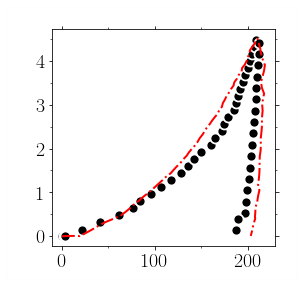

grain_indx= 42


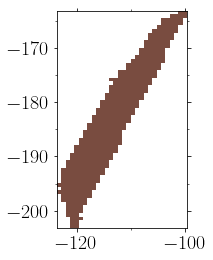

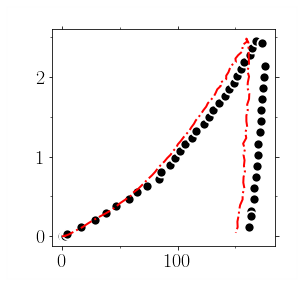

grain_indx= 43


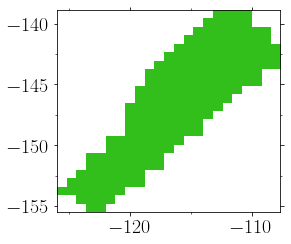

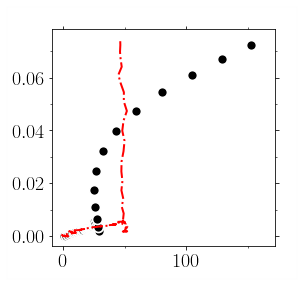

grain_indx= 44


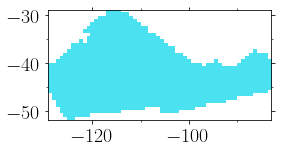

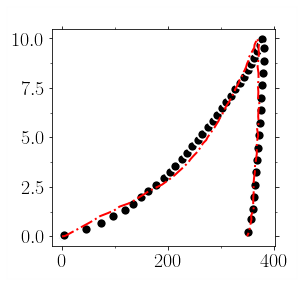

grain_indx= 45


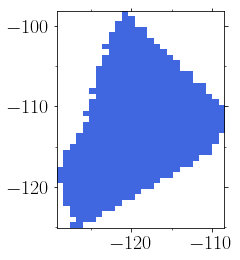

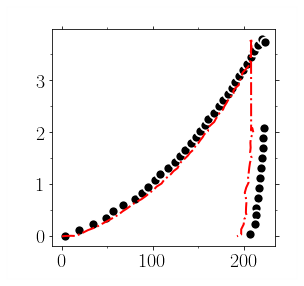

grain_indx= 46


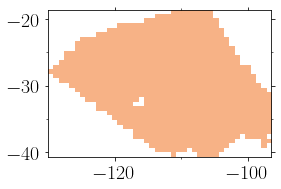

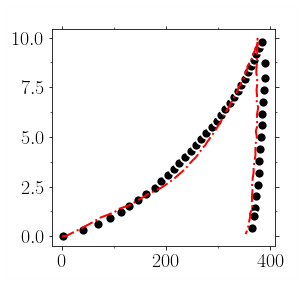

grain_indx= 47


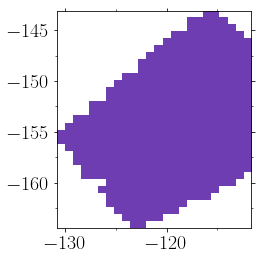

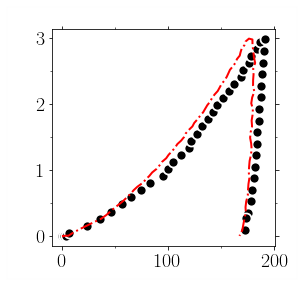

grain_indx= 48


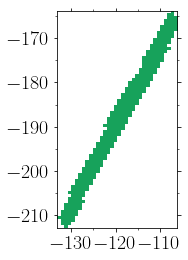

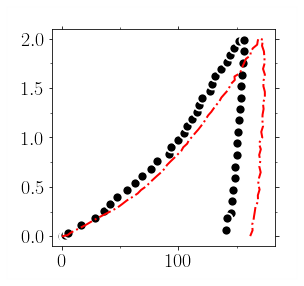

grain_indx= 50


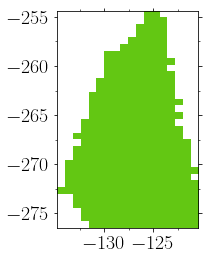

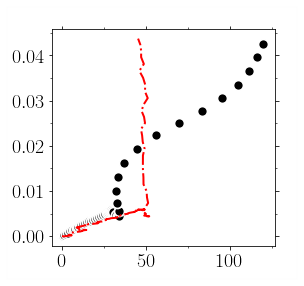

grain_indx= 51


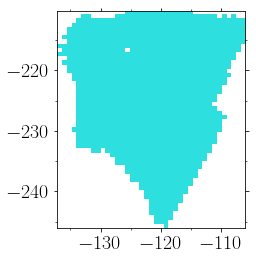

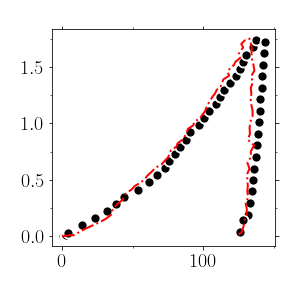

grain_indx= 52


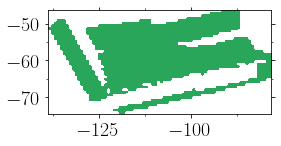

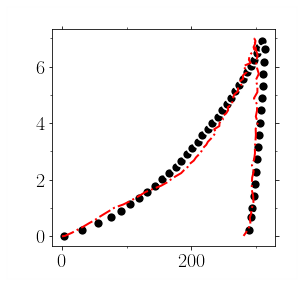

grain_indx= 53


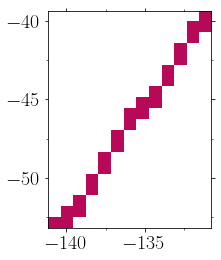

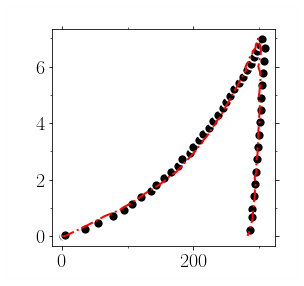

grain_indx= 55


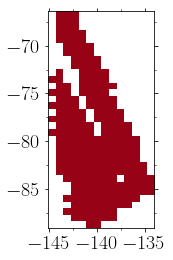

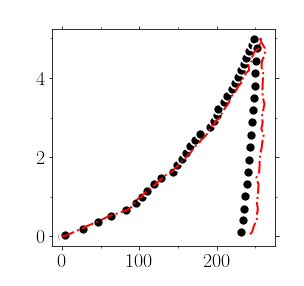

grain_indx= 56


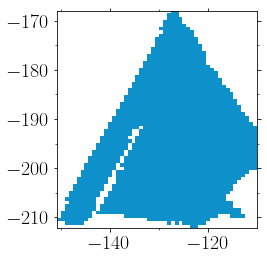

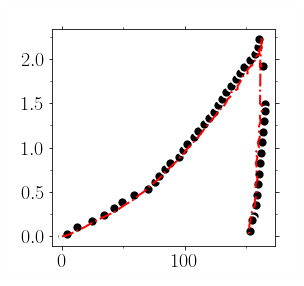

grain_indx= 57


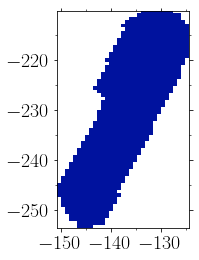

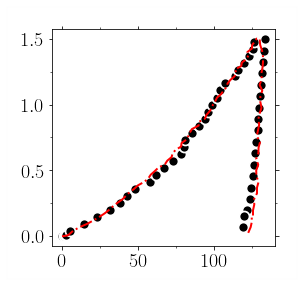

grain_indx= 59


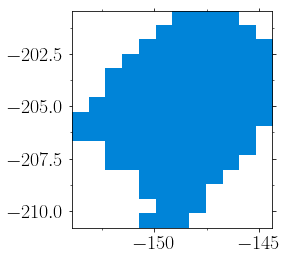

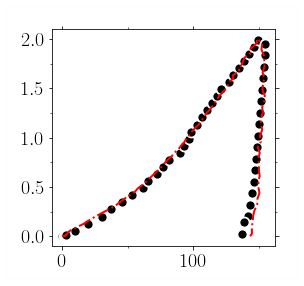

grain_indx= 60


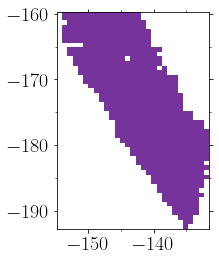

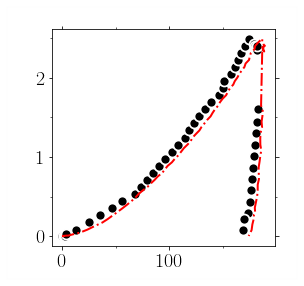

grain_indx= 63


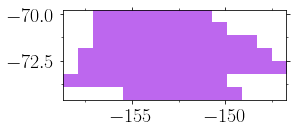

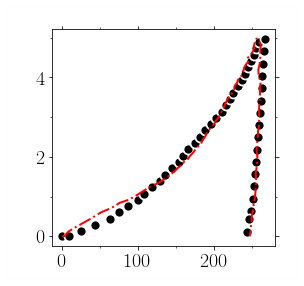

grain_indx= 64


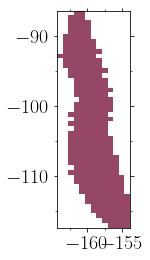

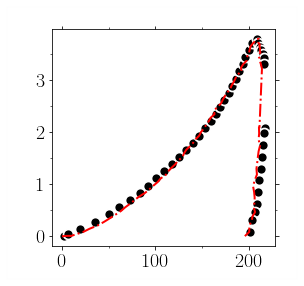

grain_indx= 65


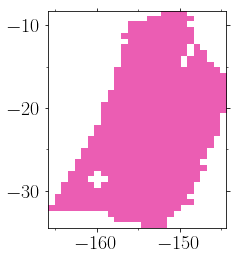

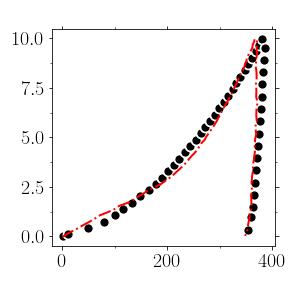

grain_indx= 67


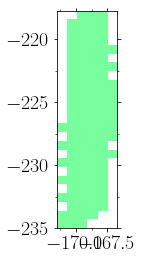

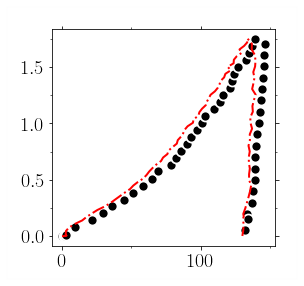

grain_indx= 69


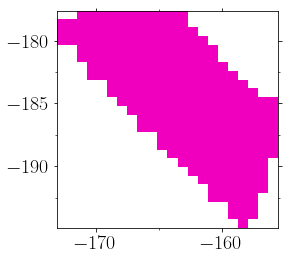

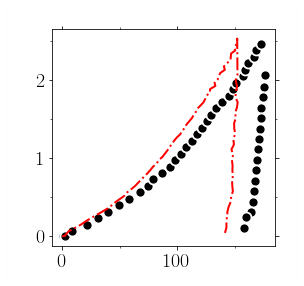

grain_indx= 70


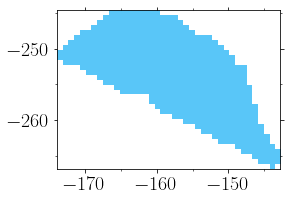

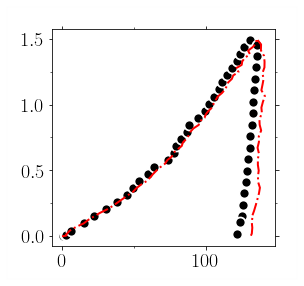

grain_indx= 71


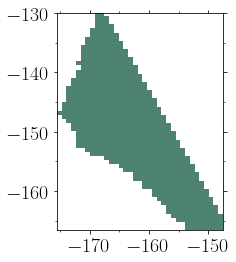

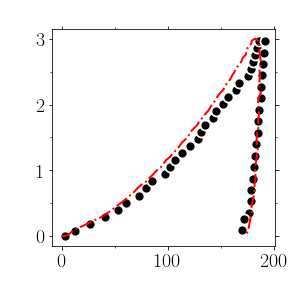

grain_indx= 72


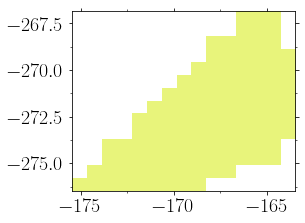

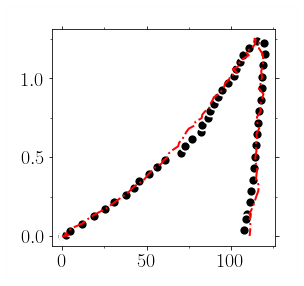

grain_indx= 74


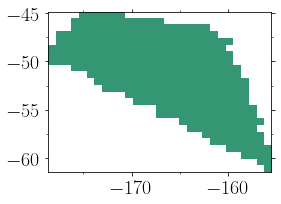

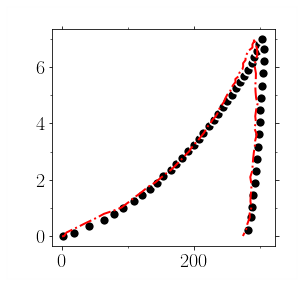

grain_indx= 75


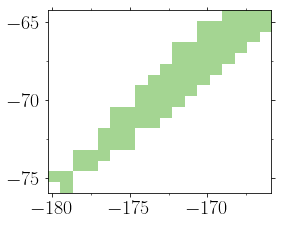

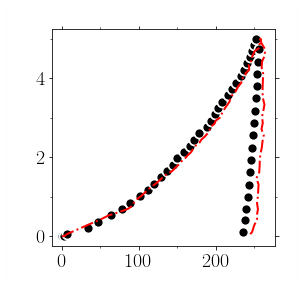

grain_indx= 76


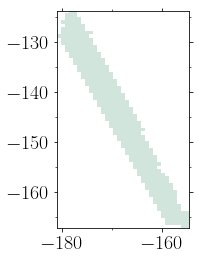

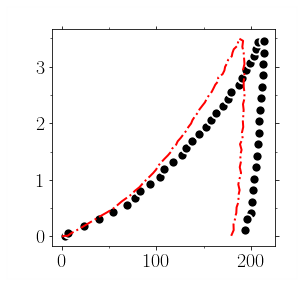

grain_indx= 77


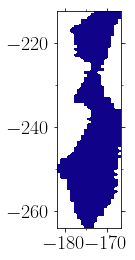

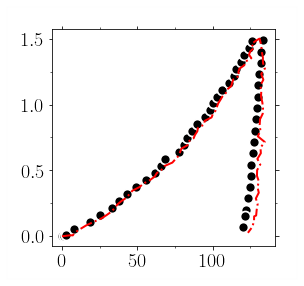

grain_indx= 79


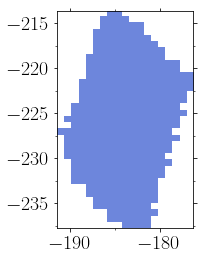

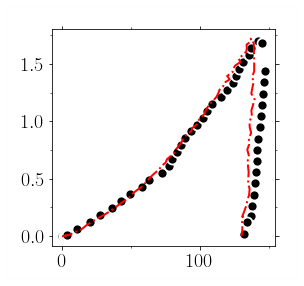

grain_indx= 80


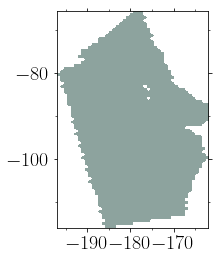

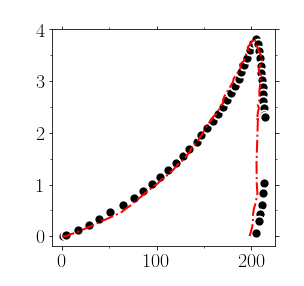

grain_indx= 82


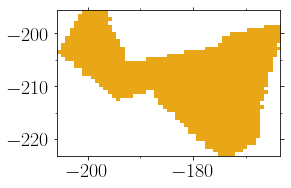

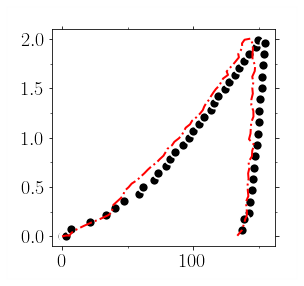

grain_indx= 83


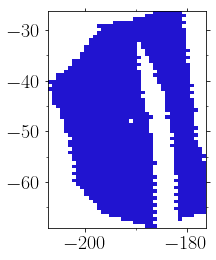

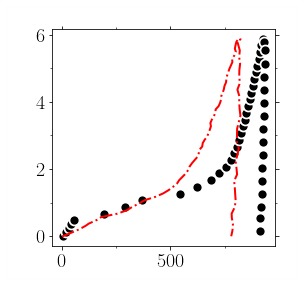

grain_indx= 84


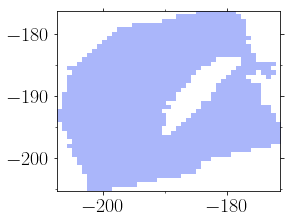

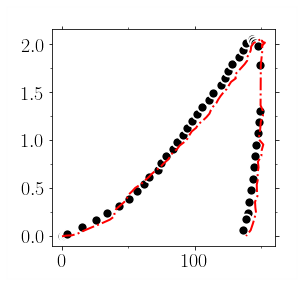

grain_indx= 86


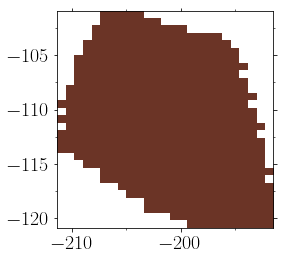

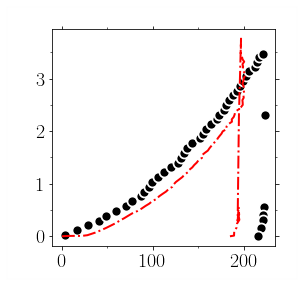

grain_indx= 87


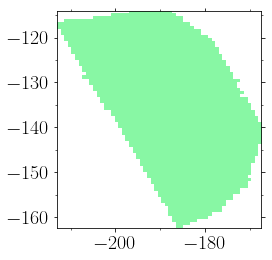

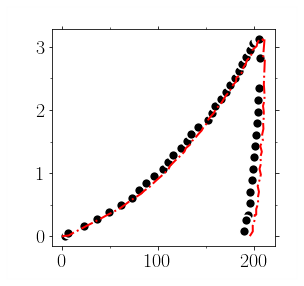

grain_indx= 88


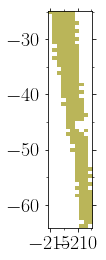

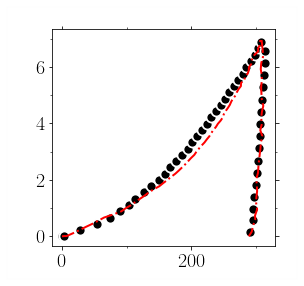

grain_indx= 89


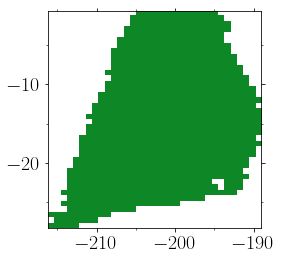

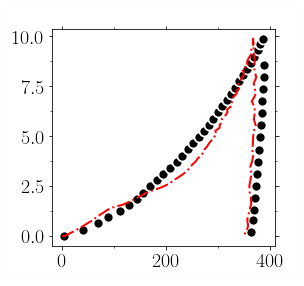

grain_indx= 90


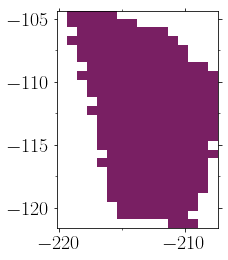

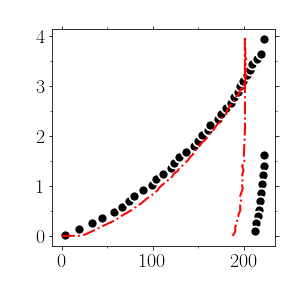

grain_indx= 91


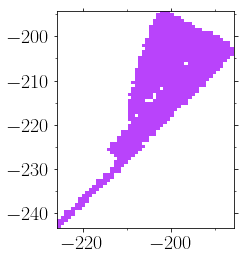

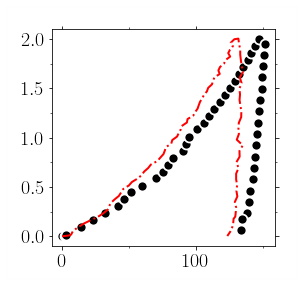

grain_indx= 93


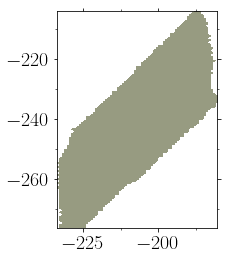

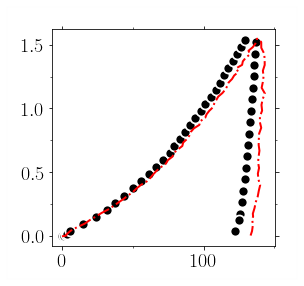

grain_indx= 94


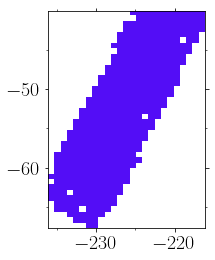

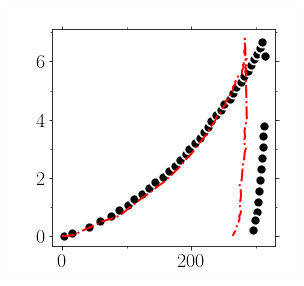

grain_indx= 96


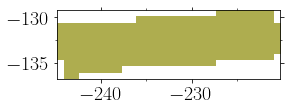

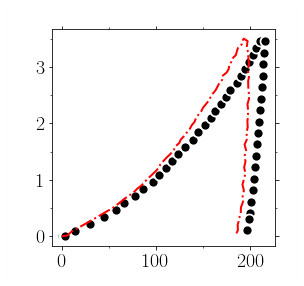

grain_indx= 97


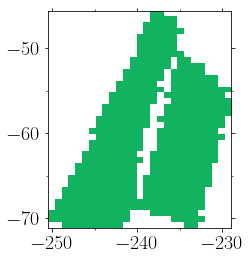

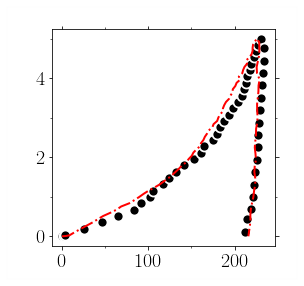

grain_indx= 98


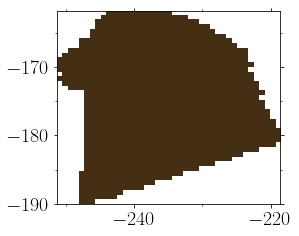

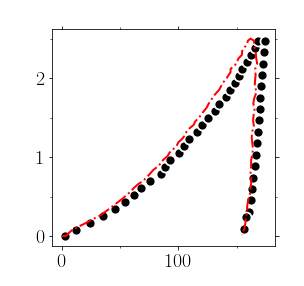

grain_indx= 99


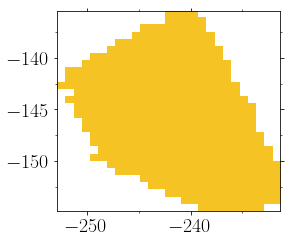

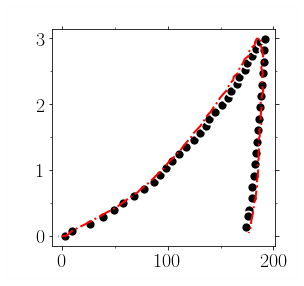

grain_indx= 101


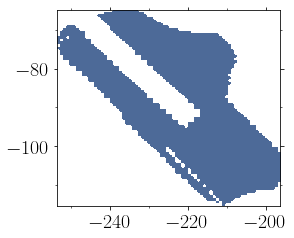

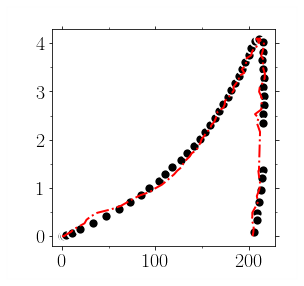

grain_indx= 104


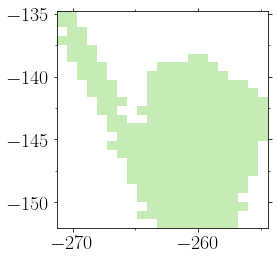

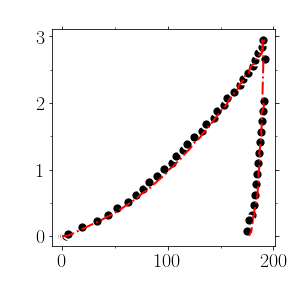

grain_indx= 105


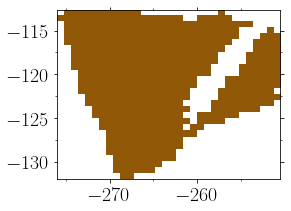

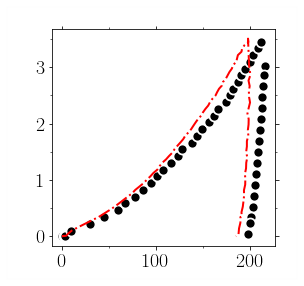

grain_indx= 106


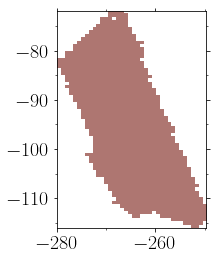

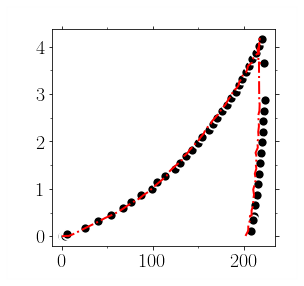

grain_indx= 107


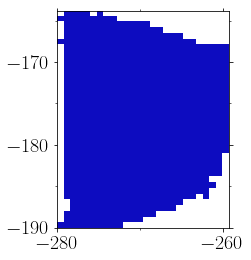

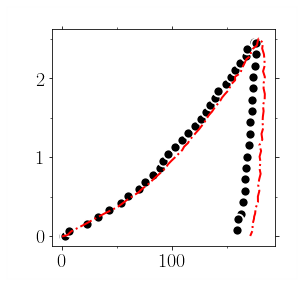

grain_indx= 109


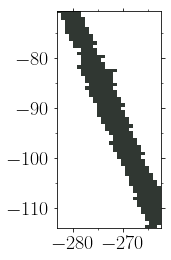

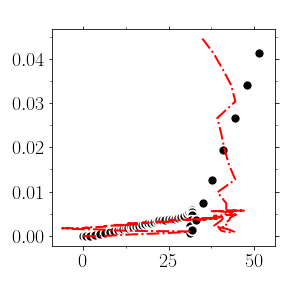

grain_indx= 110


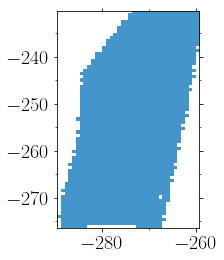

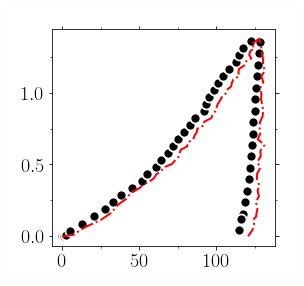

grain_indx= 112


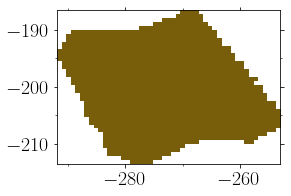

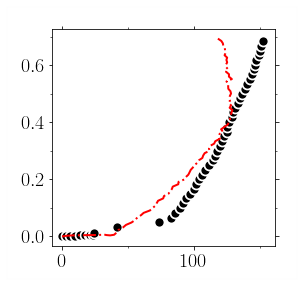

grain_indx= 113


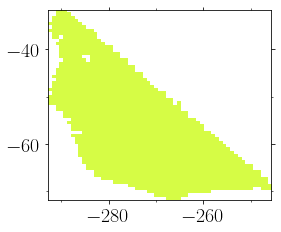

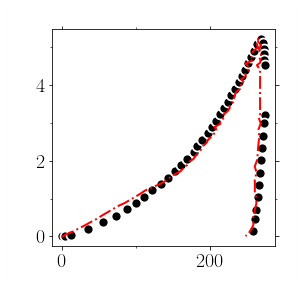

grain_indx= 114


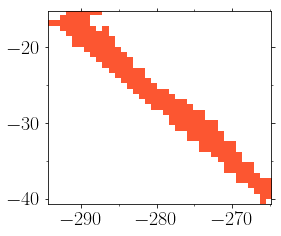

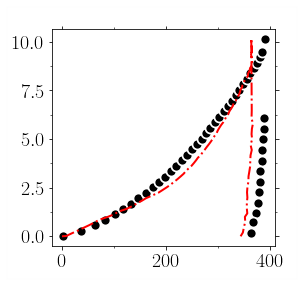

grain_indx= 115


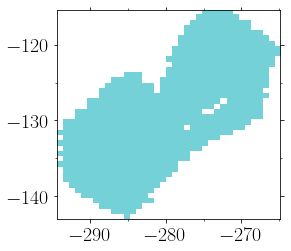

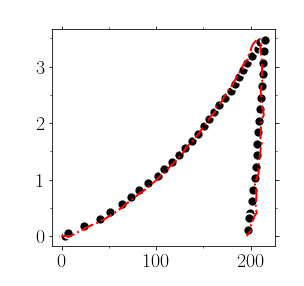

grain_indx= 119


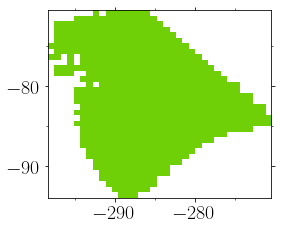

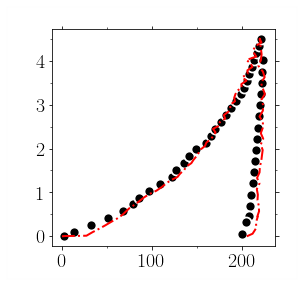

grain_indx= 120


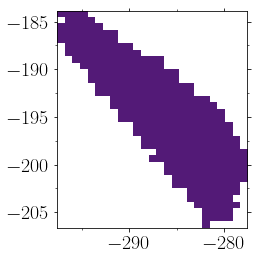

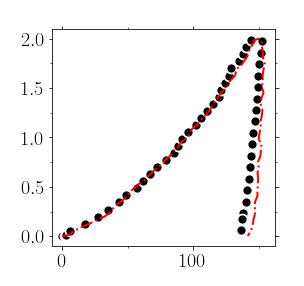

grain_indx= 123


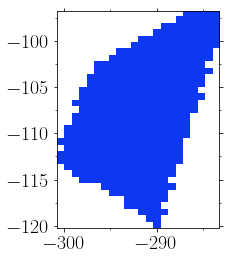

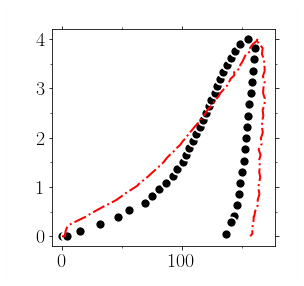

grain_indx= 125


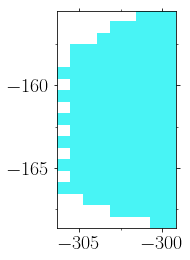

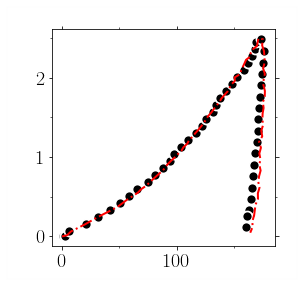

grain_indx= 126


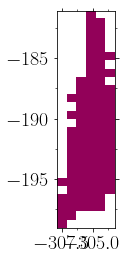

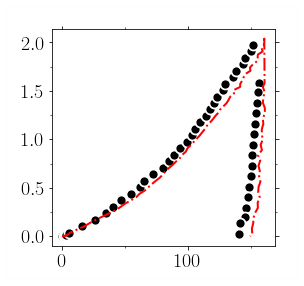

grain_indx= 127


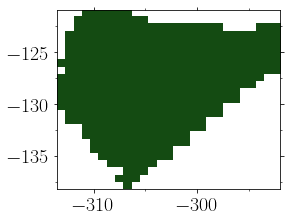

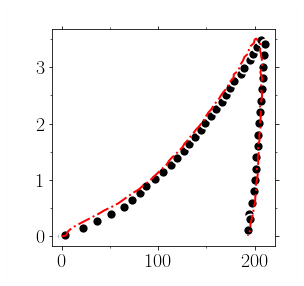

grain_indx= 128


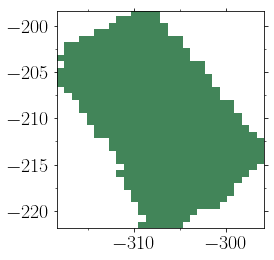

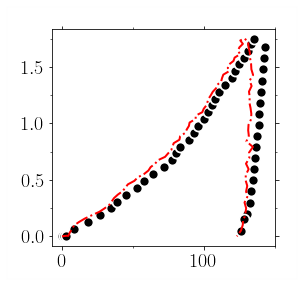

grain_indx= 129


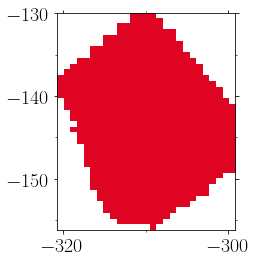

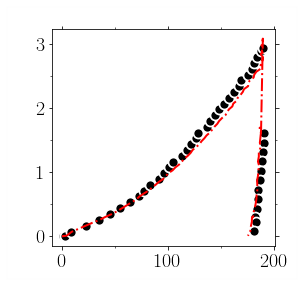

In [157]:

# for grain_indx in range(len(target_nodes_np)):
#     if not train_mask_np[grain_indx]:
#         continue
#     print('grain_indx=',grain_indx)
#     ax=utl.PltErr(None,None,Plot=False)
#     utl.PltErr(
# #                range(len(target_nodes_np[grain_indx])),
#                target_nodes_np[grain_indx], 
#                forces[grain_indx],
#                attrs=symbols.GetAttrs(count=0,fmt='.',nevery=2),
#                 Plot=False,
#                ax=ax
#                  )

#     utl.PltErr(
#                best_output[grain_indx], #step_output[grain_indx],#best_output[grain_indx],
#                        forces[grain_indx],
#                attrs={'fmt':'-.','lw':2,'color':'red'},
#                ax=ax,
#                Plot=False,
#               )
    
#     utl.PltErr(None,None,
#                ax=ax,
#                title='png/prediction%s.png'%grain_indx,
#               dpi=55,
#                 xstr='depth',
#                 ystr='load',
#               )

    
count = 0
for grain_indx in range(len(target_nodes_np)):
    !mkdir -p png/train_set
    
    if not train_mask_np[grain_indx]:
        continue
    print('grain_indx=',grain_indx)
    #--- plot grains
    #--- mask every grain_indx != GrainIndex
    GrainIndex=grain_indx
    mask = np.zeros(test_data_grains.shape[0],dtype=bool)
    mask[GrainIndex]=True
    grainID_masked = np.c_[test_data_grains[~mask]['#grainID']].astype(int)

    #--- plot
    plott = PlotGrains( np.loadtxt('%s/../id_matrix.txt'%confParser['test data files']['load_depth_path']) #--- bitmap of grain ids
                      )
    plott.Bounds(np.c_[test_data_grains[['x','y']]])
    #
    plott.Transform()
    #
    plott.Mask(grainID_masked)
    #
    plott.sub_matrix()
    #
    plott.PlotOrientationSingle(title='png/train_set/grain_indx%s_train.png'%count)
    
    ax=utl.PltErr(None,None,Plot=False)
    utl.PltErr(
#                range(len(target_nodes_np[grain_indx])),
               target_nodes_np[grain_indx], 
               forces[grain_indx],
               attrs=symbols.GetAttrs(count=0,fmt='.',nevery=2),
                Plot=False,
               ax=ax
                 )

    ax=utl.PltErr(
               best_output[grain_indx], #step_output[grain_indx],#best_output[grain_indx],
                       forces[grain_indx],

               attrs={'fmt':'-.','lw':2,'color':'red'},
               ax=ax,
               Plot=False,
              )
    
    utl.PltErr(None,None,
               ax=ax,
               title='png/train_set/prediction%s_train.png'%count,
              dpi=150,
#                xstr='depth',
#                ystr='load',
               DrawFrame=(0.2,0.1,0.15,0.1,0.01),
              )

    count += 1
    

### test set

grain_indx= 2


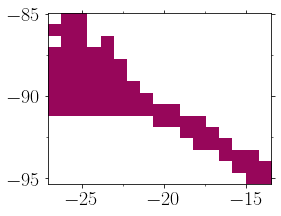

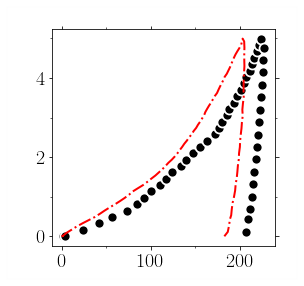

In [201]:
count = 0
for grain_indx in range(len(target_nodes_np)):
    !mkdir -p png/test_set
    
    if not test_mask_np[grain_indx]:
        continue
    print('grain_indx=',grain_indx)
    #--- plot grains
    #--- mask every grain_indx != GrainIndex
    GrainIndex=grain_indx
    mask = np.zeros(test_data_grains.shape[0],dtype=bool)
    mask[GrainIndex]=True
    grainID_masked = np.c_[test_data_grains[~mask]['#grainID']].astype(int)

    #--- plot
    plott = PlotGrains( np.loadtxt('%s/../id_matrix.txt'%confParser['test data files']['load_depth_path']) #--- bitmap of grain ids
                      )
    plott.Bounds(np.c_[test_data_grains[['x','y']]])
    #
    plott.Transform()
    #
    plott.Mask(grainID_masked)
    #
    plott.sub_matrix()
    #
    plott.PlotOrientationSingle(title='png/test_set/grain_indx%s.png'%count)
    
    ax=utl.PltErr(None,None,Plot=False)
    utl.PltErr(
#                range(len(target_nodes_np[grain_indx])),
               target_nodes_np[grain_indx], 
               forces[grain_indx],
               attrs=symbols.GetAttrs(count=0,fmt='.',nevery=2),
                Plot=False,
               ax=ax
                 )

    ax=utl.PltErr(
               best_output[grain_indx], #step_output[grain_indx],#best_output[grain_indx],
                       forces[grain_indx],

               attrs={'fmt':'-.','lw':2,'color':'red'},
               ax=ax,
               Plot=False,
              )
    
    utl.PltErr(None,None,
               ax=ax,
               title='png/test_set/prediction%s.png'%count,
              dpi=150,
#                xstr='depth',
#                ystr='load',
               DrawFrame=(0.2,0.1,0.15,0.1,0.01),
              )
    count += 1
    

test set: actual
test set: prediction


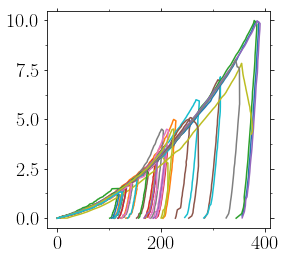

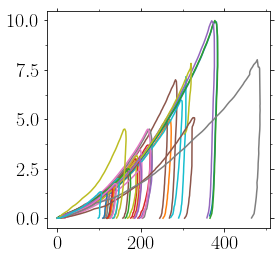

In [164]:
print('test set: actual')
ax=utl.PltErr(None,None,Plot=False)
for grain_indx in range(len(target_nodes_np)):
    if not test_mask_np[grain_indx]:
        continue

    utl.PltErr(
               target_nodes_np[grain_indx], 
                forces[grain_indx],
#               best_output[grain_indx],
               attrs={'fmt':'-'},
    #            xlim=(xmin,xmax),
    #           ylim=(xmin,xmax),
    #           title = 'png/hardness.png',
#                xstr='disp',
#                ystr='load',
               ax=ax,
                               Plot=False,

              )
    
print('test set: prediction')
ax=utl.PltErr(None,None,Plot=False)
for grain_indx in range(len(target_nodes_np)):
    if not test_mask_np[grain_indx]:
        continue

    utl.PltErr(
               best_output[grain_indx],
                        forces[grain_indx],

               attrs={'fmt':'-'},
    #            xlim=(xmin,xmax),
    #           ylim=(xmin,xmax),
    #           title = 'png/hardness.png',
#                xstr='disp',
#                ystr='load',
               ax=ax,
                               Plot=False,

              )

# predict hardness

In [166]:
class Hardness(PlotGrains):
    '''
    compute and return hardness
    arguments:
        best_output     - ML prediction
        target_nodes_np - target vector
        test_mask_np    - test set
    '''
    
    def __init__(self,target_nodes_np,
                 train_mask_np,
                 test_mask_np,
                 best_output,
                 id_matrix
                ):
        self.target_nodes_np = target_nodes_np
        self.test_mask_np = test_mask_np
        self.train_mask_np = train_mask_np
        self.best_output = best_output
        
        PlotGrains.__init__(self,id_matrix)
        pass

    
    def GetMaxForce(self,confParser):
        '''
        return max force in LD curves
        '''
        test_data_file_path = confParser['test data files']['test_data_file_path']
        test_data_file_path2nd = confParser['test data files']['test_data_file_path2nd']
        test_data_grains, test_data_grains2nd = load_test_data(test_data_file_path, 
                                                 test_data_file_path2nd
                                                )
        ngrains = test_data_grains.shape[0]


        #--- prescribed range for displacements 

        #--- loop over indented grains
        TestData.ld_curve = {}
        TestData.load = {}
        for fp,count in zip(finder.files,range(len(finder.files))): 
            test_data = TestData(path_ld='%s/%s'%(confParser['test data files']['load_depth_path'],fp),
                             path_gb=confParser['test data files']['test_data_file_path'],
                             verbose=False,
                            )
            test_data.Parse()
        #    if not test_data.is_included(xlo,xhi): #--- ld curve includes this range
        #        continue
            try:
                GrainIndex = test_data.GetGrainIndex()
            except:
                continue
            #--- 1.0e-9 and 1.0e-3: get si units
            #--- assemble feature matrix: append displacements and forces
            TestData.Append(GrainIndex,[test_data.data[:,0].max()],[test_data.data[:,1].max()]) 

        #--- predictors are the displacements
        predictors = TestData.BuildFeature(TestData.ld_curve, 
                                           ngrains,
                                           1
                                          )
        
        

        #---- forces
        self.forces2 = TestData.BuildFeature(TestData.load, 
                                           ngrains,
                                           1
                                          )

    def GetH(self,
             disp,
             forces,
             mask,
             test_data_grains,
             verbose=True):
        '''
        return hardness
        '''
        mean_force_array = np.mean(forces[~np.any(np.isnan(forces),axis=1)],axis=0) #--- replace missing data by the average
        fmax = np.mean(self.forces2[~np.isnan(self.forces2)])
        isnan = np.any(np.isnan(forces),axis=1)
        
        h_pred = []
        indx = []
        ids = []
        self.mask=mask
        for grain_indx in range(len(disp)):
            if not mask[grain_indx]:
                continue
            if verbose:
                print('grain_indx=',grain_indx)

            #--- scale by max force
            disp_pred   = np.array(disp[grain_indx])#kam * \
#            (self.forces2[grain_indx] if not isnan[grain_indx] else fmax) 

            force = (forces[grain_indx] if not isnan[grain_indx] else mean_force_array) #kam *\
            #(self.forces2[grain_indx] if not isnan[grain_indx] else fmax)

            ld_pred=pd.DataFrame(np.c_[range(disp_pred.shape[0]),1.0e-9*disp_pred, 1.0e-3*force],
                            columns=['Time','Depth','Force'])
            try:
                h_pred += [1.0e-9*self.MeasureHardness(ld_pred,Plot=False,verbose=verbose)]
                indx += [grain_indx]
                ids += [test_data_grains['#grainID'].iloc[grain_indx]]
            except:
#                traceback.print_exc()
                if verbose:
                    utl.PltErr(ld_pred.Depth,ld_pred.Force,
                               xstr=r'Depth(nm)',
                               ystr=r'Load(mN)',
                              )


                    print('grain_indx=%s:could not infer hardness!'%grain_indx)
                continue

        return pd.DataFrame(np.c_[ids,h_pred],columns=['#grainID','h(Gpa)'])

    def func(self,x,a,b):
            return a * x + b

    def MeasureHardness(self,ld,Plot=False,verbose=False):
        '''
        calculate hardness
        '''
        pmax = ld.Force.max()
        tunload = ld.Time[ld.Force>=pmax].iloc[-1]
        dt = 0.4 * tunload
        filtr = np.all([ld.Time>tunload,ld.Time<tunload+dt],axis=0)
        z = np.polyfit(ld.Depth[filtr],ld.Force[filtr],deg=1)
        if Plot:
            utl.PltErr(ld.Time[filtr],ld.Force[filtr],
                      xstr=r'Time(s)',
                       ystr=r'Load(mN)',
                      )

            utl.PltErr(ld.Time[filtr],ld.Depth[filtr],
                       xstr=r'Time(s)',
                       ystr=r'Depth(nm)',
                      )

            ax=utl.PltErr(ld.Depth,ld.Force,
                         Plot=False,
                         )
#            utl.PltErr(ld.Depth,self.func(ld.Depth,*z),
#                       fmt='-.r',
#                       label=r'$s=%3.2f$'%z[0],
#                        legend = True,
#                       ax=ax,
#                       xstr=r'Depth(nm)',
#                       ystr=r'Load(mN)',
#                       xlim=(hlo,hhi),
#                      )

            ax=utl.PltErr(ld.Depth[filtr],ld.Force[filtr],
                         Plot=False,
                         )
#            utl.PltErr(ld.Depth[filtr],func(ld.Depth[filtr],*z),
#                       fmt='-.r',
#                       label=r'$s=%3.2f$'%z[0],
#                       legend = True,
#                       ax=ax,
#                       xstr=r'Depth(nm)',
#                       ystr=r'Load(mN)',
#                      )

        pmax = ld.Force.max()#*1e-3 #--- mN
        hmax = ld.Depth.max()#*1e-9 #--- nm
        slope=z[0] #*1e-3/1e-9
        hs = 0.72 * pmax / slope
        hc = hmax - hs
        area = 24.5 * hc * hc 

        hardness = pmax / area
        if verbose:
            print('hardness=%3.2f Gpa'%(1e-9*hardness))

        return hardness

    def Plot(self,h_pred,h_actual,**kwargs):
        xmin,xmax=np.min(h_actual['h(Gpa)']),np.max(h_actual['h(Gpa)'])
        ymin,ymax=np.min(h_pred['h(Gpa)']),np.max(h_pred['h(Gpa)'])
        minn=.9*np.min([xmin,ymin]) if not 'minn' in kwargs else kwargs['minn']
        maxx=1.1*np.max([xmax,ymax]) if not 'maxx' in kwargs else kwargs['maxx']
        ax=utl.PltErr([minn,maxx],[minn,maxx],Plot=False,
                      attrs={'fmt':'-.r'}
                     )
        utl.PltErr(np.array(h_actual['h(Gpa)']),
                  np.array(h_pred['h(Gpa)']),
                   attrs={'fmt':'x','markersize':12},
                   xlim=(minn,maxx),
                   ylim=(minn,maxx),
                   xstr='actual',
                   ystr='prediction',
                   ax=ax,
                   **kwargs
                  )
        self.mse = mean_squared_error(h_actual['h(Gpa)'],h_pred['h(Gpa)'])
        #np.savetxt('mse/mse.txt',np.c_[mean_squared_error(h_actual,h_pred)],header='mse')
        print('mse=',self.mse)
        return (minn,maxx)
        
        
    def Bitmap(self,test_data_grains,h,**kwargs):
        self.reshape( np.c_[h['#grainID']],np.c_[h['h(Gpa)']])
        self.Bounds(np.c_[test_data_grains[['x','y']]])
        self.Transform()
        self.TransformField()
        grainID_notindented = np.c_[test_data_grains['#grainID'][~self.mask]]
        self.MaskField(grainID_notindented)
        self.Mask(grainID_notindented)
        self.PlotField(mask = self.id_matrix.T == 0,**kwargs)




## h_act

open and load data from test_data.csv complete.
actual
mask called


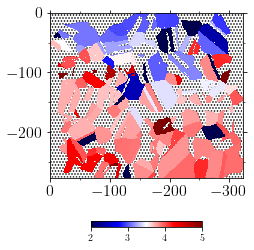

In [202]:
#hardness map
hard = Hardness(target_nodes_np,
                train_mask_np,
                test_mask_np,
                best_output,
                np.loadtxt('%s/../id_matrix.txt'%confParser['test data files']['load_depth_path']) 
               )
hard.GetMaxForce(confParser)
h_actual = hard.GetH(
            target_nodes_np, #--- actual disp
            forces, #--- force vector
          np.any([test_mask_np,train_mask_np],axis=0), #--- filter grains
          test_data_grains, #--- grain properties
          verbose=False)
# h_pred = hard.GetH(
#             best_output, #--- predicted disp
#             forces, #--- force vector
#           np.any([test_mask_np,train_mask_np],axis=0), #--- filter grains
#           test_data_grains, #--- grain properties
#           verbose=False)

# limits = hard.Plot(h_pred,h_actual,
#                   title='png/scatterPlotValidation.png',
#                   )
# dh=pd.DataFrame(np.c_[h_pred['#grainID'],(h_pred['h(Gpa)']/h_actual['h(Gpa)']-1).abs()],
#                 columns=['#grainID','h(Gpa)'])
print('actual')
hard.Bitmap(test_data_grains,
            h_actual,
            vminmax=(2.0,5),#limits,
            cmap=['jet','gray','rainbow','seismic','bwr'][3],
#            fracy=(-100,0),
            orientation='horizontal',
            interpolation='none',
            title='png/actual_hmap.png',
            pad=0.2,
            fontsize=16,
           )



## scatter plot: test

open and load data from test_data.csv complete.


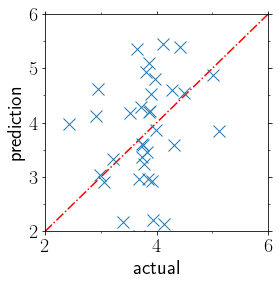

mse= 577.8666374671092
prediction


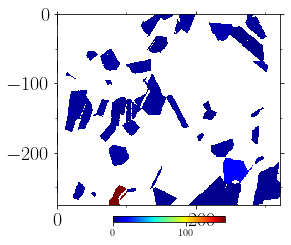

In [68]:
#--- test data
hard = Hardness(target_nodes_np,
                train_mask_np,
                test_mask_np,
                best_output,
                np.loadtxt('%s/../id_matrix.txt'%confParser['test data files']['load_depth_path']) 
               )
hard.GetMaxForce(confParser)
h_actual = hard.GetH(
            target_nodes_np, #--- actual disp
            forces, #--- force vector
          test_mask_np, #--- filter grains: test set
          test_data_grains, #--- grain properties
          verbose=False)
h_pred = hard.GetH(
            best_output, #--- predicted disp
            forces, #--- force vector
          test_mask_np,
          test_data_grains, #--- grain properties
          verbose=False)
#--- scatter plot
limits = hard.Plot(h_pred,h_actual,
#                  title='png/scatterPlotValidation.png',
                   minn=2.0,maxx=6.0,
                  )
np.savetxt('mse/scatter_test.txt',np.c_[h_pred['h(Gpa)'],h_actual['h(Gpa)']],header='prediction\tactual')

dh=pd.DataFrame(np.c_[h_pred['#grainID'],(h_pred['h(Gpa)'])],
                columns=['#grainID','h(Gpa)'])
print('prediction')
hard.Bitmap(test_data_grains,
            dh,
#            vminmax=limits,
            cmap=['jet','gray','rainbow','seismic','bwr'][0],
#            fracy=(-100,0),
            orientation='horizontal',
            interpolation='none',
#            title='png/validation.png'
           )





## scatter plot: train

open and load data from test_data.csv complete.


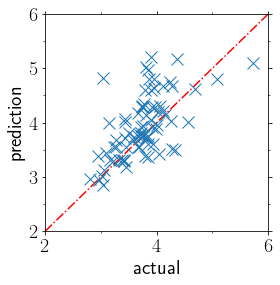

mse= 16.901511022615107
prediction


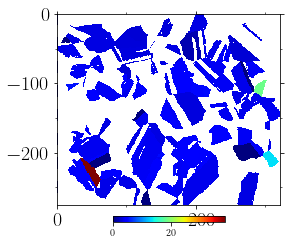

In [65]:
#--- test data
hard = Hardness(target_nodes_np,
                train_mask_np,
                test_mask_np,
                best_output,
                np.loadtxt('%s/../id_matrix.txt'%confParser['test data files']['load_depth_path']) 
               )
hard.GetMaxForce(confParser)
h_actual = hard.GetH(
            target_nodes_np, #--- actual disp
            forces, #--- force vector
          train_mask_np, #--- filter grains: train set
          test_data_grains, #--- grain properties
          verbose=False)
h_pred = hard.GetH(
            best_output, #--- predicted disp
            forces, #--- force vector
          train_mask_np,
          test_data_grains, #--- grain properties
          verbose=False)
#--- scatter plot
limits = hard.Plot(h_pred,h_actual,
#                  title='png/scatterPlotValidation.png',
                   minn=2.0,maxx=6.0,
                  )
np.savetxt('mse/scatter_train.txt',np.c_[h_pred['h(Gpa)'],h_actual['h(Gpa)']],header='prediction\tactual')

dh=pd.DataFrame(np.c_[h_pred['#grainID'],(h_pred['h(Gpa)'])],
                columns=['#grainID','h(Gpa)'])
print('prediction')
hard.Bitmap(test_data_grains,
            dh,
#            vminmax=limits,
            cmap=['jet','gray','rainbow','seismic','bwr'][0],
#            fracy=(-100,0),
            orientation='horizontal',
            interpolation='none',
#            title='png/validation.png'
           )





## plot scatter data

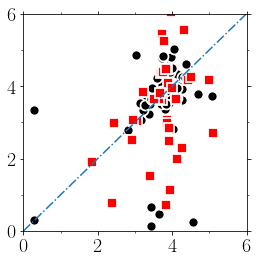

In [18]:
if not eval(confParser['flags']['remote_machine']):
    symbols=utl.Symbols()
    #
    legend=utl.Legends()
    legend.Set(bbox_to_anchor=(0.0,0.5,0.5,0.5))

    ax = utl.PltErr(None,None,Plot=False)

    h_train = np.loadtxt('hardness_best_train/Run0/mse/scatter_train.txt')
    h_test = np.loadtxt('hardness_best_train/Run0/mse/scatter_test.txt')

    utl.PltErr(h_train[:,1],h_train[:,0],
               ax=ax,
               attrs=symbols.GetAttrs(count=0,label=r'$\mathrm{Train}$',fmt='.'),
               Plot=False)
    utl.PltErr(h_test[:,1],h_test[:,0],
                attrs=symbols.GetAttrs(count=1,label=r'$\mathrm{Test}$',fmt='.'),
               ax=ax,Plot=False)

    utl.PltErr([0,6],[0,6],
               attrs={'fmt':'-.','color':'C0'},
#               yscale='log',
#               legend=legend.Get(),
               title = 'mse/validation_scatter.png',
#               ylim=(2,6),xlim=(2,6),
               ylim=(0,6),xlim=(0,6),
#               xticks=(['$\mathrm{Set}1$','$\mathrm{Set}2$','$\mathrm{Set}3$','$\mathrm{Set}4$','$\mathrm{Set}5$','$\mathrm{Set}6$'],
#                       [0,1,2,3,4,5]),
               Plot=False,
               ax=ax)

In [13]:
np.mean(utl.Zscore(h_train[:,1])*utl.Zscore(h_train[:,0]))

0.5527108146268254

In [16]:
filterr=h_test[:,0]<10
np.mean(utl.Zscore(h_test[:,1][filterr])*utl.Zscore(h_test[:,0][filterr]))

0.2828005315437518

## h_act-h_pred

open and load data from test_data.csv complete.


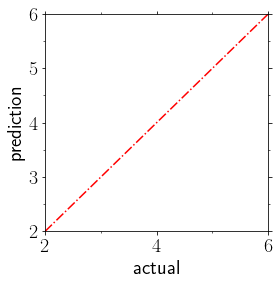

mse= 46415256.35055503
prediction


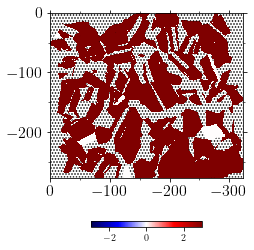

In [163]:
#hardness map
hard = Hardness(target_nodes_np,
                train_mask_np,
                test_mask_np,
                best_output,
                np.loadtxt('%s/../id_matrix.txt'%confParser['test data files']['load_depth_path']) 
               )
hard.GetMaxForce(confParser)
h_actual = hard.GetH(
            target_nodes_np, #--- actual disp
            forces, #--- force vector
          np.any([test_mask_np,train_mask_np],axis=0), #--- filter grains
          test_data_grains, #--- grain properties
          verbose=False)
h_pred = hard.GetH(
            best_output, #--- predicted disp
            forces, #--- force vector
          np.any([test_mask_np,train_mask_np],axis=0), #--- filter grains
          test_data_grains, #--- grain properties
          verbose=False)
# h_actual = hard.GetH(
#             target_nodes_np, #--- actual disp
#             forces, #--- force vector
#           np.any([test_mask_np,train_mask_np],axis=0), #--- filter grains
#           test_data_grains, #--- grain properties
#           verbose=False)

limits = hard.Plot(h_pred,h_actual,
                  title='png/scatterPlotValidation.png',
                   minn=2.0,maxx=6.0,
                  )
# dh=pd.DataFrame(np.c_[h_pred['#grainID'],(h_pred['h(Gpa)']/h_actual['h(Gpa)']-1).abs()],
#                 columns=['#grainID','h(Gpa)'])
dh=pd.DataFrame(np.c_[h_pred['#grainID'],h_pred['h(Gpa)']-h_actual['h(Gpa)']],
                columns=['#grainID','h(Gpa)'])
print('prediction')
hard.Bitmap(test_data_grains,
            dh,
            vminmax=(-3.0,3.0),
            cmap=['jet','gray','rainbow','seismic','bwr'][3],
#            fracy=(-100,0),
            orientation='horizontal',
            interpolation='none',
            title='png/dh.png',
            pad=0.2,
            fontsize=16,
           )





## h_pred

open and load data from test_data.csv complete.


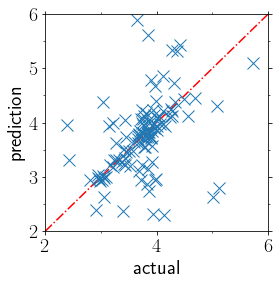

mse= 15.710623340773553
prediction
mask called


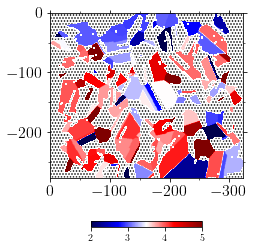

In [203]:
#hardness map
hard = Hardness(target_nodes_np,
                train_mask_np,
                test_mask_np,
                best_output,
                np.loadtxt('%s/../id_matrix.txt'%confParser['test data files']['load_depth_path']) 
               )
hard.GetMaxForce(confParser)
h_actual = hard.GetH(
            target_nodes_np, #--- actual disp
            forces, #--- force vector
          np.any([test_mask_np,train_mask_np],axis=0), #--- filter grains
          test_data_grains, #--- grain properties
          verbose=False)
h_pred = hard.GetH(
            best_output, #--- predicted disp
            forces, #--- force vector
          np.any([test_mask_np,train_mask_np],axis=0), #--- filter grains
          test_data_grains, #--- grain properties
          verbose=False)

limits = hard.Plot(h_pred,h_actual,
                  title='png/scatterPlotValidation.png',
                   minn=2.0,maxx=6.0,
                  )
# dh=pd.DataFrame(np.c_[h_pred['#grainID'],(h_pred['h(Gpa)']/h_actual['h(Gpa)']-1).abs()],
#                 columns=['#grainID','h(Gpa)'])
print('prediction')
hard.Bitmap(test_data_grains,
            h_pred,
            vminmax=(2.0,5),#limits,
            cmap=['jet','gray','rainbow','seismic','bwr'][3],
#            fracy=(-100,0),
            orientation='horizontal',
#            interpolation='bilinear',
            title='png/predicted_hmap.png',
            pad=0.2,
            fontsize=16,
           )



